#### Importing the necessary packages:

In [1]:
# Standard packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Train-test split creation
from sklearn.model_selection import train_test_split
# Oversampling
from imblearn.over_sampling import SMOTE
# Pipeline creation
from imblearn.pipeline import Pipeline
# Performing search over tuning grid
from sklearn.model_selection import GridSearchCV, StratifiedKFold
# Transforming columns to arrays
from sklearn.compose import ColumnTransformer
# Standardazing the data
from sklearn.preprocessing import StandardScaler
# Importing the performance metrics
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, recall_score, precision_score, auc, roc_curve, confusion_matrix, f1_score
# The Logistic Regression
from sklearn.linear_model import LogisticRegression
# The KNN classifier
from sklearn.neighbors import KNeighborsClassifier
# The LGBM classifier
import lightgbm as ltb
# Surpress warning
import warnings
warnings.filterwarnings("ignore")

### Creation of different data sets for different models:

I start by importing the various data sets.

In [2]:
# Financial fundamentals
FF = pd.read_csv('FF_features.csv')

# Restatements
RES = pd.read_csv('Res_cases.csv')

# CIK's of the restatements
res_ciks = pd.read_csv('res_ciks.csv')

# Readability features
read = pd.read_csv('read_features.csv')

# Topic features
topic = pd.read_csv('topic_features.csv')

# Sentiment features
sen = pd.read_csv('sent_features.csv')

# Cosine similarity
sim = pd.read_csv('cos_sim.csv')

# Changing the type of some columns for later standardization
sen['Pos_MDA'] = sen['Pos_MDA'].astype('float')
sen['Neg_MDA'] = sen['Neg_MDA'].astype('float')
read['Length_MDA'] = read['Length_MDA'].astype('float')

sen['Pos_Q1'] = sen['Pos_Q1'].astype('float')
sen['Neg_Q1'] = sen['Neg_Q1'].astype('float')
read['Length_Q1'] = read['Length_Q1'].astype('float')

sen['Pos_Q2'] = sen['Pos_Q2'].astype('float')
sen['Neg_Q2'] = sen['Neg_Q2'].astype('float')
read['Length_Q2'] = read['Length_Q2'].astype('float')

sen['Pos_Q3'] = sen['Pos_Q3'].astype('float')
sen['Neg_Q3'] = sen['Neg_Q3'].astype('float')
read['Length_Q3'] = read['Length_Q3'].astype('float')

sen['Pos_Q4'] = sen['Pos_Q4'].astype('float')
sen['Neg_Q4'] = sen['Neg_Q4'].astype('float')
read['Length_Q4'] = read['Length_Q4'].astype('float')

Then we merge the data for the baseline models.

In [3]:
# Changing year to integer for merging
FF['year'] = FF['year'].astype('int')
RES['fraud'] = RES['fraud'].astype('int')

# Merging FF and RES based on year and cik, keeping all rows of FF and only the matching of RES
merged = pd.merge(FF, RES, on=['year', 'cik'], how = 'outer', indicator = True)
merged = merged[merged['_merge'] != 'right_only']

# Adding a column for the target variable
merged['Target'] = merged['_merge'].apply(lambda x: 1 if x == 'both' else 0)
merged = merged.drop(columns=['_merge'])

# Changing the NA's to 0
merged['fraud'] = merged['fraud'].fillna(0)
merged['res'] = merged['res'].fillna(0)

# Eclude Non-FRs ciks of firms that have had a restatement to prevent leakage
exclude_cik = res_ciks['cik'].tolist()
merged = merged[~((merged['cik'].isin(exclude_cik)) & (merged['Target'] != 1))]

# Finally, we drop any na's
baseline = merged.dropna()

Next we make 3 extra dataframes, one containing MD&A features, one containing ECT features, and one containing both plus cosine similarity.

In [4]:
# We drop a column which has been included by mistake
topic = topic.drop(columns='Unnamed: 0')

# Defining the MD&A features
read_mda = read[['cik','year','FOG_MDA','Length_MDA']]
topic_mda = topic[['cik','year', 'Topic_MDA']]
sen_mda = sen[['cik','year','Pos_MDA','Pol_MDA','Sub_MDA','Neg_MDA']]

# Defining the ECT features
read_ect = read[['cik','year','FOG_Q1','Length_Q1','FOG_Q2','Length_Q2',
                'FOG_Q3','Length_Q3','FOG_Q4','Length_Q4']]
topic_ect = topic[['cik','year','Topic_Q1','Topic_Q2','Topic_Q3','Topic_Q4']]
sen_ect = sen[['cik','year','Pos_MDA','Pol_MDA','Sub_MDA','Neg_MDA', 'Pos_Q1','Pol_Q1','Sub_Q1','Neg_Q1',
              'Pos_Q2','Pol_Q2','Sub_Q2','Neg_Q2', 'Pos_Q3','Pol_Q3','Sub_Q3','Neg_Q3',
              'Pos_Q4','Pol_Q4','Sub_Q4','Neg_Q4']]

# Merging the data together for the MD&A dataframe
merged = pd.merge(baseline, read_mda, on=['year', 'cik'], how = 'inner')
merged = pd.merge(merged, topic_mda, on=['year', 'cik'], how = 'inner')
merged = pd.merge(merged, sen_mda, on=['year', 'cik'], how = 'inner')
mda_model = merged.dropna()
mda_model = mda_model.drop_duplicates(subset=['cik','year'])

# Creating dummies for the topics, year, and industry
mda_model['Topic_MDA'] = mda_model['Topic_MDA'].astype('category')
mda_model['year'] = mda_model['year'].astype('category')
mda_model['SIC'] = mda_model['SIC'].astype('category')
mda_model = pd.get_dummies(mda_model, columns=['Topic_MDA', 'year', 'SIC'])

# Merging the data together for the ECT dataframe
merged = pd.merge(baseline, read_ect, on=['year', 'cik'], how = 'inner')
merged = pd.merge(merged, topic_ect, on=['year', 'cik'], how = 'inner')
merged = pd.merge(merged, sen_ect, on=['year', 'cik'], how = 'inner')
ect_model = merged.dropna()
ect_model = ect_model.drop_duplicates(subset=['cik','year'])

# Creating dummies for the topics, year, and industry
ect_model['Topic_Q1'] = ect_model['Topic_Q1'].astype('category')
ect_model['Topic_Q2'] = ect_model['Topic_Q2'].astype('category')
ect_model['Topic_Q3'] = ect_model['Topic_Q3'].astype('category')
ect_model['Topic_Q4'] = ect_model['Topic_Q4'].astype('category')
ect_model['year'] = ect_model['year'].astype('category')
ect_model['SIC'] = ect_model['SIC'].astype('category')
ect_model = pd.get_dummies(ect_model, columns=['Topic_Q1', 'Topic_Q2', 'Topic_Q3', 'Topic_Q4','year', 'SIC'])

# Merging the data together for the full dataframe
merged = pd.merge(baseline, read, on=['year', 'cik'], how = 'inner')
merged = pd.merge(merged, topic, on=['year', 'cik'], how = 'inner')
merged = pd.merge(merged, sen, on=['year', 'cik'], how = 'inner')
merged = pd.merge(merged, sim, on=['year', 'cik'], how = 'inner')
full_model = merged.dropna()
full_model = full_model.drop_duplicates(subset=['cik','year'])

# Creating dummies for the topics, year, and industry
full_model['Topic_Q1'] = full_model['Topic_Q1'].astype('category')
full_model['Topic_Q2'] = full_model['Topic_Q2'].astype('category')
full_model['Topic_Q3'] = full_model['Topic_Q3'].astype('category')
full_model['Topic_Q4'] = full_model['Topic_Q4'].astype('category')
full_model['Topic_MDA'] = full_model['Topic_MDA'].astype('category')
full_model['year'] = full_model['year'].astype('category')
full_model['SIC'] = full_model['SIC'].astype('category')
full_model = pd.get_dummies(full_model, columns=['Topic_Q1', 'Topic_Q2', 'Topic_Q3', 'Topic_Q4', 'Topic_MDA', 'year', 'SIC'])

# Finally, we create dummies for the baseline year and industry
baseline['year'] = baseline['year'].astype('category')
baseline['SIC'] = baseline['SIC'].astype('category')
baseline = pd.get_dummies(baseline, columns=['year','SIC'])

### Defining ECM

I define a function of ECM that can both be used for tuning as for final performance. It considers a range of thresholds and returns the minimum ECM score of these thresholds. This is done to ensure that the lowest ECM is returned instead of the ECM at the default thresholds of the models.

In [6]:
# Defining the parameters for ECM
P_FR = 0.0324
P_NonFR = (1 - P_FR)
C_FP = 1
C_FN = 20

In [7]:
# Defining thresholds and number of thresholds for the tuning of ECM
rlr_p_range = np.arange(0.45, 0.55, 0.0001) 
rlr_n_thresholds = len(rlr_p_range)

# Defining the function for the performance metric in the gridsearch
def RLR_ECM(y_test, y_pred_prob):
    ecm_scores = np.zeros(rlr_n_thresholds)
    for i, p in enumerate(rlr_p_range):
        y_pred = np.where(y_pred_prob >= p, 1, 0)
        fn = np.sum((y_test == 1) & (y_pred == 0))
        fp = np.sum((y_test == 0) & (y_pred == 1))
        p = np.sum(y_test == 1)
        n = np.sum(y_test == 0)
        score = C_FN * P_FR * (fn/p) + C_FP * P_NonFR * (fp/(n-p))
        ecm_scores[i] = score
    return np.min(ecm_scores)

# Creating a scorer based on ECM
rlr_scoring = make_scorer(RLR_ECM, greater_is_better=False, needs_proba=True)

In [13]:
# Defining thresholds and number of thresholds for the tuning of ECM
knn_p_range = np.arange(0.5, 1.0, 0.0005) 
knn_n_thresholds = len(knn_p_range)

# Defining the function for the performance metric in the gridsearch
def KNN_ECM(y_test, y_pred_prob):
    ecm_scores = np.zeros(knn_n_thresholds)
    for i, p in enumerate(knn_p_range):
        y_pred = np.where(y_pred_prob >= p, 1, 0)
        fn = np.sum((y_test == 1) & (y_pred == 0))
        fp = np.sum((y_test == 0) & (y_pred == 1))
        p = np.sum(y_test == 1)
        n = np.sum(y_test == 0)
        score = C_FN * P_FR * (fn/p) + C_FP * P_NonFR * (fp/(n-p))
        ecm_scores[i] = score
    return np.min(ecm_scores)

# Creating a scorer based on ECM
knn_scoring = make_scorer(KNN_ECM, greater_is_better=False, needs_proba=True)

In [14]:
# Defining thresholds and number of thresholds for the tuning of ECM
lgbm_p_range = np.arange(0.0, 0.1, 0.0001) 
lgbm_n_thresholds = len(lgbm_p_range)

# Defining the function for the performance metric in the gridsearch
def LGBM_ECM(y_test, y_pred_prob):
    ecm_scores = np.zeros(lgbm_n_thresholds)
    for i, p in enumerate(lgbm_p_range):
        y_pred = np.where(y_pred_prob >= p, 1, 0)
        fn = np.sum((y_test == 1) & (y_pred == 0))
        fp = np.sum((y_test == 0) & (y_pred == 1))
        p = np.sum(y_test == 1)
        n = np.sum(y_test == 0)
        score = C_FN * P_FR * (fn/p) + C_FP * P_NonFR * (fp/(n-p))
        ecm_scores[i] = score
    return np.min(ecm_scores)

# Creating a scorer based on ECM
lgbm_scoring = make_scorer(LGBM_ECM, greater_is_better=False, needs_proba=True)

In [163]:
# Defining a function that will eventually extract the best ECM for the optimal threshold
def ECM(y_test, y_pred):
    fn = np.sum((y_test == 1) & (y_pred == 0))
    fp = np.sum((y_test == 0) & (y_pred == 1))    
    p = np.sum(y_test == 1)
    n = np.sum(y_test == 0)
    
    score = C_FN * P_FR * (fn/p) + C_FP * P_NonFR * (fp/n)
    return score

### Splitting Target variable and Features

In [8]:
# Basline
y_b = pd.Series(data=baseline['Target'])
X_b = baseline.drop(columns=['cik','fraud', 'res', 'Target'])

# MD&A
y_m = pd.Series(data=mda_model['Target'])
X_m = mda_model.drop(columns=['cik','fraud', 'res', 'Target'])

# ECT
y_e = pd.Series(data=ect_model['Target'])
X_e = ect_model.drop(columns=['cik','fraud', 'res', 'Target'])

# Full
y_f = pd.Series(data=full_model['Target'])
X_f = full_model.drop(columns=['cik','fraud', 'res', 'Target'])

### Creating Train-Test Split and defining CV folds

In [9]:
### Split the data set into test and train
# Baseline
X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(X_b, y_b, test_size=0.3, stratify=y_b,random_state=42)

# MD&A
X_m_train, X_m_test, y_m_train, y_m_test = train_test_split(X_m, y_m, test_size=0.3, stratify=y_m,random_state=42)

# ECT
X_e_train, X_e_test, y_e_train, y_e_test = train_test_split(X_e, y_e, test_size=0.3, stratify=y_e,random_state=42)

# Full
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_f, y_f, test_size=0.3, stratify=y_f,random_state=42)

# Defining CV folds
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=25)

### Defining numerical and non-numerical columns for standardization

In [10]:
# Numerical columns - Baseline
num_cols_b = list(X_b_train.select_dtypes(include=['float']).columns)
# Non numerical columns - Baseline
non_num_cols_b = list(X_b_train.select_dtypes(exclude=['float']).columns)

# Numerical columns - MD&A
num_cols_m = list(X_m_train.select_dtypes(include=['float']).columns)
# Non numerical columns - MD&A
non_num_cols_m = list(X_m_train.select_dtypes(exclude=['float']).columns)

# Numerical columns - ECT
num_cols_e = list(X_e_train.select_dtypes(include=['float']).columns)
# Non numerical columns - ECT
non_num_cols_e = list(X_e_train.select_dtypes(exclude=['float']).columns)

# Numerical columns - Full
num_cols_f = list(X_f_train.select_dtypes(include=['float']).columns)
# Non numerical columns - Full
non_num_cols_f = list(X_f_train.select_dtypes(exclude=['float']).columns)

## Baseline Performance

In [11]:
# Preprocessor
rlr_b_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_b),
        ('non_num', 'passthrough', non_num_cols_b)
    ])

# Pipeline steps
rlr_b_steps = [
    ("prep", rlr_b_preprocessor),
    ("over", SMOTE(random_state=42)), 
    ("lr", LogisticRegression(random_state=21, solver='lbfgs', max_iter=1000000)), 
]

# Pipeline
rlr_b_pipeline = Pipeline(rlr_b_steps)

# Set up the grid search parameters
rlr_b_parameters = {'lr__C': np.logspace(-7,1,50),
                 'lr__penalty': ['l2']}

# Setting up the GridSearch with CV
rlr_b_grid = GridSearchCV(rlr_b_pipeline, rlr_b_parameters, cv=kf, verbose = 10, scoring=rlr_scoring)

# Fit the grid search object to the training data
rlr_b_grid.fit(X_b_train, y_b_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 1/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.631 total time=   1.3s
[CV 2/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 2/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.450 total time=   0.9s
[CV 3/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 3/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.449 total time=   0.9s
[CV 4/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 4/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.576 total time=   0.7s
[CV 5/5; 1/50] START lr__C=1e-07, lr__penalty=l2................................
[CV 5/5; 1/50] END lr__C=1e-07, lr__penalty=l2;, score=-0.597 total time=   1.0s
[CV 1/5; 2/50] START lr__C=1.4563484775012443e-07, lr__penalty=l2...............
[CV 1/5; 2/50] END lr__C=1.4563484775012443e-07

[CV 2/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.416 total time=   0.9s
[CV 3/5; 10/50] START lr__C=2.94705170255181e-06, lr__penalty=l2................
[CV 3/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.414 total time=   0.7s
[CV 4/5; 10/50] START lr__C=2.94705170255181e-06, lr__penalty=l2................
[CV 4/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.487 total time=   0.8s
[CV 5/5; 10/50] START lr__C=2.94705170255181e-06, lr__penalty=l2................
[CV 5/5; 10/50] END lr__C=2.94705170255181e-06, lr__penalty=l2;, score=-0.507 total time=   0.8s
[CV 1/5; 11/50] START lr__C=4.291934260128778e-06, lr__penalty=l2...............
[CV 1/5; 11/50] END lr__C=4.291934260128778e-06, lr__penalty=l2;, score=-0.528 total time=   0.7s
[CV 2/5; 11/50] START lr__C=4.291934260128778e-06, lr__penalty=l2...............
[CV 2/5; 11/50] END lr__C=4.291934260128778e-06, lr__penalty=l2;, score=-0.411 total time=   0.8s
[CV 3/5; 11

[CV 3/5; 19/50] END lr__C=8.68511373751352e-05, lr__penalty=l2;, score=-0.395 total time=   0.8s
[CV 4/5; 19/50] START lr__C=8.68511373751352e-05, lr__penalty=l2................
[CV 4/5; 19/50] END lr__C=8.68511373751352e-05, lr__penalty=l2;, score=-0.497 total time=   0.7s
[CV 5/5; 19/50] START lr__C=8.68511373751352e-05, lr__penalty=l2................
[CV 5/5; 19/50] END lr__C=8.68511373751352e-05, lr__penalty=l2;, score=-0.567 total time=   0.8s
[CV 1/5; 20/50] START lr__C=0.00012648552168552957, lr__penalty=l2..............
[CV 1/5; 20/50] END lr__C=0.00012648552168552957, lr__penalty=l2;, score=-0.569 total time=   0.7s
[CV 2/5; 20/50] START lr__C=0.00012648552168552957, lr__penalty=l2..............
[CV 2/5; 20/50] END lr__C=0.00012648552168552957, lr__penalty=l2;, score=-0.400 total time=   0.7s
[CV 3/5; 20/50] START lr__C=0.00012648552168552957, lr__penalty=l2..............
[CV 3/5; 20/50] END lr__C=0.00012648552168552957, lr__penalty=l2;, score=-0.402 total time=   0.8s
[CV 4/5

[CV 4/5; 28/50] END lr__C=0.0025595479226995332, lr__penalty=l2;, score=-0.598 total time=   0.8s
[CV 5/5; 28/50] START lr__C=0.0025595479226995332, lr__penalty=l2...............
[CV 5/5; 28/50] END lr__C=0.0025595479226995332, lr__penalty=l2;, score=-0.696 total time=   0.9s
[CV 1/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 1/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.581 total time=   1.0s
[CV 2/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 2/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.462 total time=   0.9s
[CV 3/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 3/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.467 total time=   0.8s
[CV 4/5; 29/50] START lr__C=0.003727593720314938, lr__penalty=l2................
[CV 4/5; 29/50] END lr__C=0.003727593720314938, lr__penalty=l2;, score=-0.601 total time=   0.8s
[CV 5/5; 29

[CV 1/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.534 total time=   1.1s
[CV 2/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 2/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.431 total time=   1.2s
[CV 3/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 3/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.512 total time=   1.3s
[CV 4/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 4/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.548 total time=   1.3s
[CV 5/5; 38/50] START lr__C=0.10985411419875572, lr__penalty=l2.................
[CV 5/5; 38/50] END lr__C=0.10985411419875572, lr__penalty=l2;, score=-0.633 total time=   1.2s
[CV 1/5; 39/50] START lr__C=0.15998587196060574, lr__penalty=l2.................
[CV 1/5; 39/50] END lr__C=0.15998587196060574, lr__penalty=l2;, score=-0.520 total time=   1.3s
[CV 2/5; 39/50] STA

[CV 3/5; 47/50] END lr__C=3.2374575428176398, lr__penalty=l2;, score=-0.647 total time=   1.6s
[CV 4/5; 47/50] START lr__C=3.2374575428176398, lr__penalty=l2..................
[CV 4/5; 47/50] END lr__C=3.2374575428176398, lr__penalty=l2;, score=-0.596 total time=   1.4s
[CV 5/5; 47/50] START lr__C=3.2374575428176398, lr__penalty=l2..................
[CV 5/5; 47/50] END lr__C=3.2374575428176398, lr__penalty=l2;, score=-0.644 total time=   1.4s
[CV 1/5; 48/50] START lr__C=4.714866363457389, lr__penalty=l2...................
[CV 1/5; 48/50] END lr__C=4.714866363457389, lr__penalty=l2;, score=-0.493 total time=   1.6s
[CV 2/5; 48/50] START lr__C=4.714866363457389, lr__penalty=l2...................
[CV 2/5; 48/50] END lr__C=4.714866363457389, lr__penalty=l2;, score=-0.577 total time=   1.6s
[CV 3/5; 48/50] START lr__C=4.714866363457389, lr__penalty=l2...................
[CV 3/5; 48/50] END lr__C=4.714866363457389, lr__penalty=l2;, score=-0.646 total time=   1.7s
[CV 4/5; 48/50] START lr__C=

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ARtS',
                                                                          'ARtTA',
                                                                          'AFDA',
                                                                          'AFDAtAR',
                                                                          'AFDAtNS',
                                                                          'Zscore',
                                                                          'Big4',
                                                                          'cItS',
                                        

Minimum validation error: 0.464
Best parameter value: 1.9306977288832496e-05


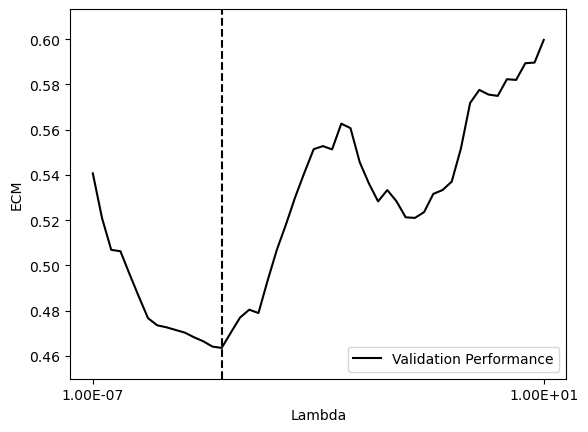

In [12]:
# Getting the average test scores
rlr_b_test_scores = abs(rlr_b_grid.cv_results_['mean_test_score'])

# Plotting the test scores
fig, ax = plt.subplots()
ax.plot(rlr_b_test_scores, label='Validation Performance', color='black')
ax.legend(loc='best')

# Setting x-axis ticks and labels
param_values = rlr_b_grid.param_grid['lr__C']
x_ticks = [0, len(param_values)-1]
x_labels = [f'{param_values[0]:.2E}', f'{param_values[-1]:.2E}']
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)

# Setting y-axis range and label
y_max = max(rlr_b_test_scores)
y_min = min(rlr_b_test_scores)
y_range = y_max - y_min
ax.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)
ax.set_ylabel('ECM')

# Setting x-axis label
ax.set_xlabel('Lambda')

# Printing the minimum validation ECM and the index of the best parameter
min_score = round(min(rlr_b_test_scores), 3)
best_param_idx = np.argmin(rlr_b_test_scores)
best_param_value = param_values[best_param_idx]
print(f'Minimum validation error: {min_score}')
print(f'Best parameter value: {best_param_value}')

# Adding vertical line at minimum validation error
ax.axvline(x=best_param_idx, linestyle='--', color='black')

plt.show()
fig.savefig("rlr_param.jpg", dpi=300, bbox_inches='tight')

In [15]:
# Preprocessor
knn_b_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_b),
        ('non_num', 'passthrough', non_num_cols_b)
    ])

# Pipeline steps
knn_b_steps = [
    ("prep", knn_b_preprocessor),
    ("over", SMOTE(random_state=42)), 
    ("knn", KNeighborsClassifier())
]

# Pipeline
knn_b_pipeline = Pipeline(knn_b_steps)

# Set up the grid search parameters
knn_b_parameters = {'knn__n_neighbors': np.arange(1, 100, 2),
                    'knn__p': [1,2],
                   'knn__weights': ['uniform', 'distance']}

# Setting up the GridSearch with CV
knn_b_grid = GridSearchCV(knn_b_pipeline, knn_b_parameters, cv=kf, verbose = 10, scoring=knn_scoring)

# Fit the grid search object to the training data
knn_b_grid.fit(X_b_train, y_b_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5; 1/200] START knn__n_neighbors=1, knn__p=1, knn__weights=uniform........
[CV 1/5; 1/200] END knn__n_neighbors=1, knn__p=1, knn__weights=uniform;, score=-0.561 total time=   3.8s
[CV 2/5; 1/200] START knn__n_neighbors=1, knn__p=1, knn__weights=uniform........
[CV 2/5; 1/200] END knn__n_neighbors=1, knn__p=1, knn__weights=uniform;, score=-0.635 total time=   3.8s
[CV 3/5; 1/200] START knn__n_neighbors=1, knn__p=1, knn__weights=uniform........
[CV 3/5; 1/200] END knn__n_neighbors=1, knn__p=1, knn__weights=uniform;, score=-0.473 total time=   4.1s
[CV 4/5; 1/200] START knn__n_neighbors=1, knn__p=1, knn__weights=uniform........
[CV 4/5; 1/200] END knn__n_neighbors=1, knn__p=1, knn__weights=uniform;, score=-0.616 total time=   4.1s
[CV 5/5; 1/200] START knn__n_neighbors=1, knn__p=1, knn__weights=uniform........
[CV 5/5; 1/200] END knn__n_neighbors=1, knn__p=1, knn__weights=uniform;, score=-0.631 total time=   4.0s
[CV 1/

[CV 5/5; 9/200] END knn__n_neighbors=5, knn__p=1, knn__weights=uniform;, score=-0.622 total time=   3.5s
[CV 1/5; 10/200] START knn__n_neighbors=5, knn__p=1, knn__weights=distance......
[CV 1/5; 10/200] END knn__n_neighbors=5, knn__p=1, knn__weights=distance;, score=-0.557 total time=   3.6s
[CV 2/5; 10/200] START knn__n_neighbors=5, knn__p=1, knn__weights=distance......
[CV 2/5; 10/200] END knn__n_neighbors=5, knn__p=1, knn__weights=distance;, score=-0.661 total time=   3.5s
[CV 3/5; 10/200] START knn__n_neighbors=5, knn__p=1, knn__weights=distance......
[CV 3/5; 10/200] END knn__n_neighbors=5, knn__p=1, knn__weights=distance;, score=-0.424 total time=   3.6s
[CV 4/5; 10/200] START knn__n_neighbors=5, knn__p=1, knn__weights=distance......
[CV 4/5; 10/200] END knn__n_neighbors=5, knn__p=1, knn__weights=distance;, score=-0.577 total time=   3.6s
[CV 5/5; 10/200] START knn__n_neighbors=5, knn__p=1, knn__weights=distance......
[CV 5/5; 10/200] END knn__n_neighbors=5, knn__p=1, knn__weight

[CV 4/5; 18/200] END knn__n_neighbors=9, knn__p=1, knn__weights=distance;, score=-0.606 total time=   3.0s
[CV 5/5; 18/200] START knn__n_neighbors=9, knn__p=1, knn__weights=distance......
[CV 5/5; 18/200] END knn__n_neighbors=9, knn__p=1, knn__weights=distance;, score=-0.613 total time=   3.5s
[CV 1/5; 19/200] START knn__n_neighbors=9, knn__p=2, knn__weights=uniform.......
[CV 1/5; 19/200] END knn__n_neighbors=9, knn__p=2, knn__weights=uniform;, score=-0.494 total time=   1.1s
[CV 2/5; 19/200] START knn__n_neighbors=9, knn__p=2, knn__weights=uniform.......
[CV 2/5; 19/200] END knn__n_neighbors=9, knn__p=2, knn__weights=uniform;, score=-0.606 total time=   1.0s
[CV 3/5; 19/200] START knn__n_neighbors=9, knn__p=2, knn__weights=uniform.......
[CV 3/5; 19/200] END knn__n_neighbors=9, knn__p=2, knn__weights=uniform;, score=-0.503 total time=   1.1s
[CV 4/5; 19/200] START knn__n_neighbors=9, knn__p=2, knn__weights=uniform.......
[CV 4/5; 19/200] END knn__n_neighbors=9, knn__p=2, knn__weights

[CV 3/5; 27/200] END knn__n_neighbors=13, knn__p=2, knn__weights=uniform;, score=-0.494 total time=   0.7s
[CV 4/5; 27/200] START knn__n_neighbors=13, knn__p=2, knn__weights=uniform......
[CV 4/5; 27/200] END knn__n_neighbors=13, knn__p=2, knn__weights=uniform;, score=-0.620 total time=   0.8s
[CV 5/5; 27/200] START knn__n_neighbors=13, knn__p=2, knn__weights=uniform......
[CV 5/5; 27/200] END knn__n_neighbors=13, knn__p=2, knn__weights=uniform;, score=-0.562 total time=   0.8s
[CV 1/5; 28/200] START knn__n_neighbors=13, knn__p=2, knn__weights=distance.....
[CV 1/5; 28/200] END knn__n_neighbors=13, knn__p=2, knn__weights=distance;, score=-0.468 total time=   1.0s
[CV 2/5; 28/200] START knn__n_neighbors=13, knn__p=2, knn__weights=distance.....
[CV 2/5; 28/200] END knn__n_neighbors=13, knn__p=2, knn__weights=distance;, score=-0.576 total time=   0.8s
[CV 3/5; 28/200] START knn__n_neighbors=13, knn__p=2, knn__weights=distance.....
[CV 3/5; 28/200] END knn__n_neighbors=13, knn__p=2, knn__w

[CV 2/5; 36/200] END knn__n_neighbors=17, knn__p=2, knn__weights=distance;, score=-0.538 total time=   1.1s
[CV 3/5; 36/200] START knn__n_neighbors=17, knn__p=2, knn__weights=distance.....
[CV 3/5; 36/200] END knn__n_neighbors=17, knn__p=2, knn__weights=distance;, score=-0.469 total time=   1.0s
[CV 4/5; 36/200] START knn__n_neighbors=17, knn__p=2, knn__weights=distance.....
[CV 4/5; 36/200] END knn__n_neighbors=17, knn__p=2, knn__weights=distance;, score=-0.586 total time=   1.2s
[CV 5/5; 36/200] START knn__n_neighbors=17, knn__p=2, knn__weights=distance.....
[CV 5/5; 36/200] END knn__n_neighbors=17, knn__p=2, knn__weights=distance;, score=-0.547 total time=   1.0s
[CV 1/5; 37/200] START knn__n_neighbors=19, knn__p=1, knn__weights=uniform......
[CV 1/5; 37/200] END knn__n_neighbors=19, knn__p=1, knn__weights=uniform;, score=-0.555 total time=   3.6s
[CV 2/5; 37/200] START knn__n_neighbors=19, knn__p=1, knn__weights=uniform......
[CV 2/5; 37/200] END knn__n_neighbors=19, knn__p=1, knn_

[CV 1/5; 45/200] END knn__n_neighbors=23, knn__p=1, knn__weights=uniform;, score=-0.551 total time=   3.3s
[CV 2/5; 45/200] START knn__n_neighbors=23, knn__p=1, knn__weights=uniform......
[CV 2/5; 45/200] END knn__n_neighbors=23, knn__p=1, knn__weights=uniform;, score=-0.618 total time=   3.4s
[CV 3/5; 45/200] START knn__n_neighbors=23, knn__p=1, knn__weights=uniform......
[CV 3/5; 45/200] END knn__n_neighbors=23, knn__p=1, knn__weights=uniform;, score=-0.435 total time=   3.5s
[CV 4/5; 45/200] START knn__n_neighbors=23, knn__p=1, knn__weights=uniform......
[CV 4/5; 45/200] END knn__n_neighbors=23, knn__p=1, knn__weights=uniform;, score=-0.589 total time=   3.4s
[CV 5/5; 45/200] START knn__n_neighbors=23, knn__p=1, knn__weights=uniform......
[CV 5/5; 45/200] END knn__n_neighbors=23, knn__p=1, knn__weights=uniform;, score=-0.606 total time=   3.4s
[CV 1/5; 46/200] START knn__n_neighbors=23, knn__p=1, knn__weights=distance.....
[CV 1/5; 46/200] END knn__n_neighbors=23, knn__p=1, knn__wei

[CV 5/5; 53/200] END knn__n_neighbors=27, knn__p=1, knn__weights=uniform;, score=-0.606 total time=   3.4s
[CV 1/5; 54/200] START knn__n_neighbors=27, knn__p=1, knn__weights=distance.....
[CV 1/5; 54/200] END knn__n_neighbors=27, knn__p=1, knn__weights=distance;, score=-0.551 total time=   3.2s
[CV 2/5; 54/200] START knn__n_neighbors=27, knn__p=1, knn__weights=distance.....
[CV 2/5; 54/200] END knn__n_neighbors=27, knn__p=1, knn__weights=distance;, score=-0.618 total time=   3.4s
[CV 3/5; 54/200] START knn__n_neighbors=27, knn__p=1, knn__weights=distance.....
[CV 3/5; 54/200] END knn__n_neighbors=27, knn__p=1, knn__weights=distance;, score=-0.456 total time=   3.2s
[CV 4/5; 54/200] START knn__n_neighbors=27, knn__p=1, knn__weights=distance.....
[CV 4/5; 54/200] END knn__n_neighbors=27, knn__p=1, knn__weights=distance;, score=-0.568 total time=   3.4s
[CV 5/5; 54/200] START knn__n_neighbors=27, knn__p=1, knn__weights=distance.....
[CV 5/5; 54/200] END knn__n_neighbors=27, knn__p=1, knn_

[CV 4/5; 62/200] END knn__n_neighbors=31, knn__p=1, knn__weights=distance;, score=-0.557 total time=   3.4s
[CV 5/5; 62/200] START knn__n_neighbors=31, knn__p=1, knn__weights=distance.....
[CV 5/5; 62/200] END knn__n_neighbors=31, knn__p=1, knn__weights=distance;, score=-0.601 total time=   3.4s
[CV 1/5; 63/200] START knn__n_neighbors=31, knn__p=2, knn__weights=uniform......
[CV 1/5; 63/200] END knn__n_neighbors=31, knn__p=2, knn__weights=uniform;, score=-0.493 total time=   0.9s
[CV 2/5; 63/200] START knn__n_neighbors=31, knn__p=2, knn__weights=uniform......
[CV 2/5; 63/200] END knn__n_neighbors=31, knn__p=2, knn__weights=uniform;, score=-0.565 total time=   1.0s
[CV 3/5; 63/200] START knn__n_neighbors=31, knn__p=2, knn__weights=uniform......
[CV 3/5; 63/200] END knn__n_neighbors=31, knn__p=2, knn__weights=uniform;, score=-0.481 total time=   0.8s
[CV 4/5; 63/200] START knn__n_neighbors=31, knn__p=2, knn__weights=uniform......
[CV 4/5; 63/200] END knn__n_neighbors=31, knn__p=2, knn__w

[CV 3/5; 71/200] END knn__n_neighbors=35, knn__p=2, knn__weights=uniform;, score=-0.479 total time=   0.9s
[CV 4/5; 71/200] START knn__n_neighbors=35, knn__p=2, knn__weights=uniform......
[CV 4/5; 71/200] END knn__n_neighbors=35, knn__p=2, knn__weights=uniform;, score=-0.617 total time=   1.1s
[CV 5/5; 71/200] START knn__n_neighbors=35, knn__p=2, knn__weights=uniform......
[CV 5/5; 71/200] END knn__n_neighbors=35, knn__p=2, knn__weights=uniform;, score=-0.605 total time=   1.0s
[CV 1/5; 72/200] START knn__n_neighbors=35, knn__p=2, knn__weights=distance.....
[CV 1/5; 72/200] END knn__n_neighbors=35, knn__p=2, knn__weights=distance;, score=-0.475 total time=   1.1s
[CV 2/5; 72/200] START knn__n_neighbors=35, knn__p=2, knn__weights=distance.....
[CV 2/5; 72/200] END knn__n_neighbors=35, knn__p=2, knn__weights=distance;, score=-0.550 total time=   1.0s
[CV 3/5; 72/200] START knn__n_neighbors=35, knn__p=2, knn__weights=distance.....
[CV 3/5; 72/200] END knn__n_neighbors=35, knn__p=2, knn__w

[CV 2/5; 80/200] END knn__n_neighbors=39, knn__p=2, knn__weights=distance;, score=-0.560 total time=   1.2s
[CV 3/5; 80/200] START knn__n_neighbors=39, knn__p=2, knn__weights=distance.....
[CV 3/5; 80/200] END knn__n_neighbors=39, knn__p=2, knn__weights=distance;, score=-0.476 total time=   1.0s
[CV 4/5; 80/200] START knn__n_neighbors=39, knn__p=2, knn__weights=distance.....
[CV 4/5; 80/200] END knn__n_neighbors=39, knn__p=2, knn__weights=distance;, score=-0.593 total time=   1.1s
[CV 5/5; 80/200] START knn__n_neighbors=39, knn__p=2, knn__weights=distance.....
[CV 5/5; 80/200] END knn__n_neighbors=39, knn__p=2, knn__weights=distance;, score=-0.598 total time=   1.1s
[CV 1/5; 81/200] START knn__n_neighbors=41, knn__p=1, knn__weights=uniform......
[CV 1/5; 81/200] END knn__n_neighbors=41, knn__p=1, knn__weights=uniform;, score=-0.559 total time=   3.7s
[CV 2/5; 81/200] START knn__n_neighbors=41, knn__p=1, knn__weights=uniform......
[CV 2/5; 81/200] END knn__n_neighbors=41, knn__p=1, knn_

[CV 1/5; 89/200] END knn__n_neighbors=45, knn__p=1, knn__weights=uniform;, score=-0.559 total time=   4.0s
[CV 2/5; 89/200] START knn__n_neighbors=45, knn__p=1, knn__weights=uniform......
[CV 2/5; 89/200] END knn__n_neighbors=45, knn__p=1, knn__weights=uniform;, score=-0.606 total time=   3.9s
[CV 3/5; 89/200] START knn__n_neighbors=45, knn__p=1, knn__weights=uniform......
[CV 3/5; 89/200] END knn__n_neighbors=45, knn__p=1, knn__weights=uniform;, score=-0.476 total time=   4.0s
[CV 4/5; 89/200] START knn__n_neighbors=45, knn__p=1, knn__weights=uniform......
[CV 4/5; 89/200] END knn__n_neighbors=45, knn__p=1, knn__weights=uniform;, score=-0.601 total time=   3.8s
[CV 5/5; 89/200] START knn__n_neighbors=45, knn__p=1, knn__weights=uniform......
[CV 5/5; 89/200] END knn__n_neighbors=45, knn__p=1, knn__weights=uniform;, score=-0.615 total time=   3.9s
[CV 1/5; 90/200] START knn__n_neighbors=45, knn__p=1, knn__weights=distance.....
[CV 1/5; 90/200] END knn__n_neighbors=45, knn__p=1, knn__wei

[CV 5/5; 97/200] END knn__n_neighbors=49, knn__p=1, knn__weights=uniform;, score=-0.612 total time=   4.0s
[CV 1/5; 98/200] START knn__n_neighbors=49, knn__p=1, knn__weights=distance.....
[CV 1/5; 98/200] END knn__n_neighbors=49, knn__p=1, knn__weights=distance;, score=-0.543 total time=   3.9s
[CV 2/5; 98/200] START knn__n_neighbors=49, knn__p=1, knn__weights=distance.....
[CV 2/5; 98/200] END knn__n_neighbors=49, knn__p=1, knn__weights=distance;, score=-0.602 total time=   4.5s
[CV 3/5; 98/200] START knn__n_neighbors=49, knn__p=1, knn__weights=distance.....
[CV 3/5; 98/200] END knn__n_neighbors=49, knn__p=1, knn__weights=distance;, score=-0.473 total time=   3.9s
[CV 4/5; 98/200] START knn__n_neighbors=49, knn__p=1, knn__weights=distance.....
[CV 4/5; 98/200] END knn__n_neighbors=49, knn__p=1, knn__weights=distance;, score=-0.578 total time=   3.8s
[CV 5/5; 98/200] START knn__n_neighbors=49, knn__p=1, knn__weights=distance.....
[CV 5/5; 98/200] END knn__n_neighbors=49, knn__p=1, knn_

[CV 4/5; 106/200] END knn__n_neighbors=53, knn__p=1, knn__weights=distance;, score=-0.576 total time=   4.3s
[CV 5/5; 106/200] START knn__n_neighbors=53, knn__p=1, knn__weights=distance....
[CV 5/5; 106/200] END knn__n_neighbors=53, knn__p=1, knn__weights=distance;, score=-0.595 total time=   4.0s
[CV 1/5; 107/200] START knn__n_neighbors=53, knn__p=2, knn__weights=uniform.....
[CV 1/5; 107/200] END knn__n_neighbors=53, knn__p=2, knn__weights=uniform;, score=-0.459 total time=   1.1s
[CV 2/5; 107/200] START knn__n_neighbors=53, knn__p=2, knn__weights=uniform.....
[CV 2/5; 107/200] END knn__n_neighbors=53, knn__p=2, knn__weights=uniform;, score=-0.583 total time=   1.2s
[CV 3/5; 107/200] START knn__n_neighbors=53, knn__p=2, knn__weights=uniform.....
[CV 3/5; 107/200] END knn__n_neighbors=53, knn__p=2, knn__weights=uniform;, score=-0.479 total time=   1.1s
[CV 4/5; 107/200] START knn__n_neighbors=53, knn__p=2, knn__weights=uniform.....
[CV 4/5; 107/200] END knn__n_neighbors=53, knn__p=2, 

[CV 3/5; 115/200] END knn__n_neighbors=57, knn__p=2, knn__weights=uniform;, score=-0.501 total time=   1.3s
[CV 4/5; 115/200] START knn__n_neighbors=57, knn__p=2, knn__weights=uniform.....
[CV 4/5; 115/200] END knn__n_neighbors=57, knn__p=2, knn__weights=uniform;, score=-0.607 total time=   1.2s
[CV 5/5; 115/200] START knn__n_neighbors=57, knn__p=2, knn__weights=uniform.....
[CV 5/5; 115/200] END knn__n_neighbors=57, knn__p=2, knn__weights=uniform;, score=-0.602 total time=   1.2s
[CV 1/5; 116/200] START knn__n_neighbors=57, knn__p=2, knn__weights=distance....
[CV 1/5; 116/200] END knn__n_neighbors=57, knn__p=2, knn__weights=distance;, score=-0.462 total time=   1.2s
[CV 2/5; 116/200] START knn__n_neighbors=57, knn__p=2, knn__weights=distance....
[CV 2/5; 116/200] END knn__n_neighbors=57, knn__p=2, knn__weights=distance;, score=-0.574 total time=   1.2s
[CV 3/5; 116/200] START knn__n_neighbors=57, knn__p=2, knn__weights=distance....
[CV 3/5; 116/200] END knn__n_neighbors=57, knn__p=2, 

[CV 2/5; 124/200] END knn__n_neighbors=61, knn__p=2, knn__weights=distance;, score=-0.600 total time=   1.0s
[CV 3/5; 124/200] START knn__n_neighbors=61, knn__p=2, knn__weights=distance....
[CV 3/5; 124/200] END knn__n_neighbors=61, knn__p=2, knn__weights=distance;, score=-0.502 total time=   1.1s
[CV 4/5; 124/200] START knn__n_neighbors=61, knn__p=2, knn__weights=distance....
[CV 4/5; 124/200] END knn__n_neighbors=61, knn__p=2, knn__weights=distance;, score=-0.594 total time=   1.0s
[CV 5/5; 124/200] START knn__n_neighbors=61, knn__p=2, knn__weights=distance....
[CV 5/5; 124/200] END knn__n_neighbors=61, knn__p=2, knn__weights=distance;, score=-0.571 total time=   1.0s
[CV 1/5; 125/200] START knn__n_neighbors=63, knn__p=1, knn__weights=uniform.....
[CV 1/5; 125/200] END knn__n_neighbors=63, knn__p=1, knn__weights=uniform;, score=-0.525 total time=   3.6s
[CV 2/5; 125/200] START knn__n_neighbors=63, knn__p=1, knn__weights=uniform.....
[CV 2/5; 125/200] END knn__n_neighbors=63, knn__p=1

[CV 1/5; 133/200] END knn__n_neighbors=67, knn__p=1, knn__weights=uniform;, score=-0.530 total time=   4.2s
[CV 2/5; 133/200] START knn__n_neighbors=67, knn__p=1, knn__weights=uniform.....
[CV 2/5; 133/200] END knn__n_neighbors=67, knn__p=1, knn__weights=uniform;, score=-0.574 total time=   4.1s
[CV 3/5; 133/200] START knn__n_neighbors=67, knn__p=1, knn__weights=uniform.....
[CV 3/5; 133/200] END knn__n_neighbors=67, knn__p=1, knn__weights=uniform;, score=-0.475 total time=   4.4s
[CV 4/5; 133/200] START knn__n_neighbors=67, knn__p=1, knn__weights=uniform.....
[CV 4/5; 133/200] END knn__n_neighbors=67, knn__p=1, knn__weights=uniform;, score=-0.512 total time=   4.2s
[CV 5/5; 133/200] START knn__n_neighbors=67, knn__p=1, knn__weights=uniform.....
[CV 5/5; 133/200] END knn__n_neighbors=67, knn__p=1, knn__weights=uniform;, score=-0.643 total time=   4.3s
[CV 1/5; 134/200] START knn__n_neighbors=67, knn__p=1, knn__weights=distance....
[CV 1/5; 134/200] END knn__n_neighbors=67, knn__p=1, kn

[CV 5/5; 141/200] END knn__n_neighbors=71, knn__p=1, knn__weights=uniform;, score=-0.649 total time=   4.1s
[CV 1/5; 142/200] START knn__n_neighbors=71, knn__p=1, knn__weights=distance....
[CV 1/5; 142/200] END knn__n_neighbors=71, knn__p=1, knn__weights=distance;, score=-0.514 total time=   4.1s
[CV 2/5; 142/200] START knn__n_neighbors=71, knn__p=1, knn__weights=distance....
[CV 2/5; 142/200] END knn__n_neighbors=71, knn__p=1, knn__weights=distance;, score=-0.571 total time=   4.0s
[CV 3/5; 142/200] START knn__n_neighbors=71, knn__p=1, knn__weights=distance....
[CV 3/5; 142/200] END knn__n_neighbors=71, knn__p=1, knn__weights=distance;, score=-0.463 total time=   4.2s
[CV 4/5; 142/200] START knn__n_neighbors=71, knn__p=1, knn__weights=distance....
[CV 4/5; 142/200] END knn__n_neighbors=71, knn__p=1, knn__weights=distance;, score=-0.479 total time=   4.2s
[CV 5/5; 142/200] START knn__n_neighbors=71, knn__p=1, knn__weights=distance....
[CV 5/5; 142/200] END knn__n_neighbors=71, knn__p=1

[CV 4/5; 150/200] END knn__n_neighbors=75, knn__p=1, knn__weights=distance;, score=-0.503 total time=   4.2s
[CV 5/5; 150/200] START knn__n_neighbors=75, knn__p=1, knn__weights=distance....
[CV 5/5; 150/200] END knn__n_neighbors=75, knn__p=1, knn__weights=distance;, score=-0.649 total time=   4.2s
[CV 1/5; 151/200] START knn__n_neighbors=75, knn__p=2, knn__weights=uniform.....
[CV 1/5; 151/200] END knn__n_neighbors=75, knn__p=2, knn__weights=uniform;, score=-0.451 total time=   1.2s
[CV 2/5; 151/200] START knn__n_neighbors=75, knn__p=2, knn__weights=uniform.....
[CV 2/5; 151/200] END knn__n_neighbors=75, knn__p=2, knn__weights=uniform;, score=-0.600 total time=   1.1s
[CV 3/5; 151/200] START knn__n_neighbors=75, knn__p=2, knn__weights=uniform.....
[CV 3/5; 151/200] END knn__n_neighbors=75, knn__p=2, knn__weights=uniform;, score=-0.498 total time=   1.3s
[CV 4/5; 151/200] START knn__n_neighbors=75, knn__p=2, knn__weights=uniform.....
[CV 4/5; 151/200] END knn__n_neighbors=75, knn__p=2, 

[CV 3/5; 159/200] END knn__n_neighbors=79, knn__p=2, knn__weights=uniform;, score=-0.496 total time=   1.2s
[CV 4/5; 159/200] START knn__n_neighbors=79, knn__p=2, knn__weights=uniform.....
[CV 4/5; 159/200] END knn__n_neighbors=79, knn__p=2, knn__weights=uniform;, score=-0.649 total time=   1.4s
[CV 5/5; 159/200] START knn__n_neighbors=79, knn__p=2, knn__weights=uniform.....
[CV 5/5; 159/200] END knn__n_neighbors=79, knn__p=2, knn__weights=uniform;, score=-0.574 total time=   1.5s
[CV 1/5; 160/200] START knn__n_neighbors=79, knn__p=2, knn__weights=distance....
[CV 1/5; 160/200] END knn__n_neighbors=79, knn__p=2, knn__weights=distance;, score=-0.452 total time=   1.4s
[CV 2/5; 160/200] START knn__n_neighbors=79, knn__p=2, knn__weights=distance....
[CV 2/5; 160/200] END knn__n_neighbors=79, knn__p=2, knn__weights=distance;, score=-0.589 total time=   1.3s
[CV 3/5; 160/200] START knn__n_neighbors=79, knn__p=2, knn__weights=distance....
[CV 3/5; 160/200] END knn__n_neighbors=79, knn__p=2, 

[CV 2/5; 168/200] END knn__n_neighbors=83, knn__p=2, knn__weights=distance;, score=-0.575 total time=   1.2s
[CV 3/5; 168/200] START knn__n_neighbors=83, knn__p=2, knn__weights=distance....
[CV 3/5; 168/200] END knn__n_neighbors=83, knn__p=2, knn__weights=distance;, score=-0.495 total time=   1.2s
[CV 4/5; 168/200] START knn__n_neighbors=83, knn__p=2, knn__weights=distance....
[CV 4/5; 168/200] END knn__n_neighbors=83, knn__p=2, knn__weights=distance;, score=-0.649 total time=   1.2s
[CV 5/5; 168/200] START knn__n_neighbors=83, knn__p=2, knn__weights=distance....
[CV 5/5; 168/200] END knn__n_neighbors=83, knn__p=2, knn__weights=distance;, score=-0.560 total time=   1.2s
[CV 1/5; 169/200] START knn__n_neighbors=85, knn__p=1, knn__weights=uniform.....
[CV 1/5; 169/200] END knn__n_neighbors=85, knn__p=1, knn__weights=uniform;, score=-0.502 total time=   4.4s
[CV 2/5; 169/200] START knn__n_neighbors=85, knn__p=1, knn__weights=uniform.....
[CV 2/5; 169/200] END knn__n_neighbors=85, knn__p=1

[CV 1/5; 177/200] END knn__n_neighbors=89, knn__p=1, knn__weights=uniform;, score=-0.505 total time=   4.2s
[CV 2/5; 177/200] START knn__n_neighbors=89, knn__p=1, knn__weights=uniform.....
[CV 2/5; 177/200] END knn__n_neighbors=89, knn__p=1, knn__weights=uniform;, score=-0.565 total time=   4.6s
[CV 3/5; 177/200] START knn__n_neighbors=89, knn__p=1, knn__weights=uniform.....
[CV 3/5; 177/200] END knn__n_neighbors=89, knn__p=1, knn__weights=uniform;, score=-0.481 total time=   4.3s
[CV 4/5; 177/200] START knn__n_neighbors=89, knn__p=1, knn__weights=uniform.....
[CV 4/5; 177/200] END knn__n_neighbors=89, knn__p=1, knn__weights=uniform;, score=-0.494 total time=   4.6s
[CV 5/5; 177/200] START knn__n_neighbors=89, knn__p=1, knn__weights=uniform.....
[CV 5/5; 177/200] END knn__n_neighbors=89, knn__p=1, knn__weights=uniform;, score=-0.649 total time=   4.0s
[CV 1/5; 178/200] START knn__n_neighbors=89, knn__p=1, knn__weights=distance....
[CV 1/5; 178/200] END knn__n_neighbors=89, knn__p=1, kn

[CV 5/5; 185/200] END knn__n_neighbors=93, knn__p=1, knn__weights=uniform;, score=-0.649 total time=   4.3s
[CV 1/5; 186/200] START knn__n_neighbors=93, knn__p=1, knn__weights=distance....
[CV 1/5; 186/200] END knn__n_neighbors=93, knn__p=1, knn__weights=distance;, score=-0.496 total time=   4.0s
[CV 2/5; 186/200] START knn__n_neighbors=93, knn__p=1, knn__weights=distance....
[CV 2/5; 186/200] END knn__n_neighbors=93, knn__p=1, knn__weights=distance;, score=-0.553 total time=   4.0s
[CV 3/5; 186/200] START knn__n_neighbors=93, knn__p=1, knn__weights=distance....
[CV 3/5; 186/200] END knn__n_neighbors=93, knn__p=1, knn__weights=distance;, score=-0.473 total time=   4.1s
[CV 4/5; 186/200] START knn__n_neighbors=93, knn__p=1, knn__weights=distance....
[CV 4/5; 186/200] END knn__n_neighbors=93, knn__p=1, knn__weights=distance;, score=-0.470 total time=   4.2s
[CV 5/5; 186/200] START knn__n_neighbors=93, knn__p=1, knn__weights=distance....
[CV 5/5; 186/200] END knn__n_neighbors=93, knn__p=1

[CV 4/5; 194/200] END knn__n_neighbors=97, knn__p=1, knn__weights=distance;, score=-0.472 total time=   4.1s
[CV 5/5; 194/200] START knn__n_neighbors=97, knn__p=1, knn__weights=distance....
[CV 5/5; 194/200] END knn__n_neighbors=97, knn__p=1, knn__weights=distance;, score=-0.649 total time=   4.0s
[CV 1/5; 195/200] START knn__n_neighbors=97, knn__p=2, knn__weights=uniform.....
[CV 1/5; 195/200] END knn__n_neighbors=97, knn__p=2, knn__weights=uniform;, score=-0.474 total time=   1.2s
[CV 2/5; 195/200] START knn__n_neighbors=97, knn__p=2, knn__weights=uniform.....
[CV 2/5; 195/200] END knn__n_neighbors=97, knn__p=2, knn__weights=uniform;, score=-0.598 total time=   1.1s
[CV 3/5; 195/200] START knn__n_neighbors=97, knn__p=2, knn__weights=uniform.....
[CV 3/5; 195/200] END knn__n_neighbors=97, knn__p=2, knn__weights=uniform;, score=-0.492 total time=   1.2s
[CV 4/5; 195/200] START knn__n_neighbors=97, knn__p=2, knn__weights=uniform.....
[CV 4/5; 195/200] END knn__n_neighbors=97, knn__p=2, 

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ARtS',
                                                                          'ARtTA',
                                                                          'AFDA',
                                                                          'AFDAtAR',
                                                                          'AFDAtNS',
                                                                          'Zscore',
                                                                          'Big4',
                                                                          'cItS',
                                        

For p1_wu: Minimum validation error: 0.535
For p1_wu: Best parameter value: 93
For p1_wd: Minimum validation error: 0.529
For p1_wd: Best parameter value: 93
For p2_wu: Minimum validation error: 0.52
For p2_wu: Best parameter value: 7
For p2_wd: Minimum validation error: 0.496
For p2_wd: Best parameter value: 7


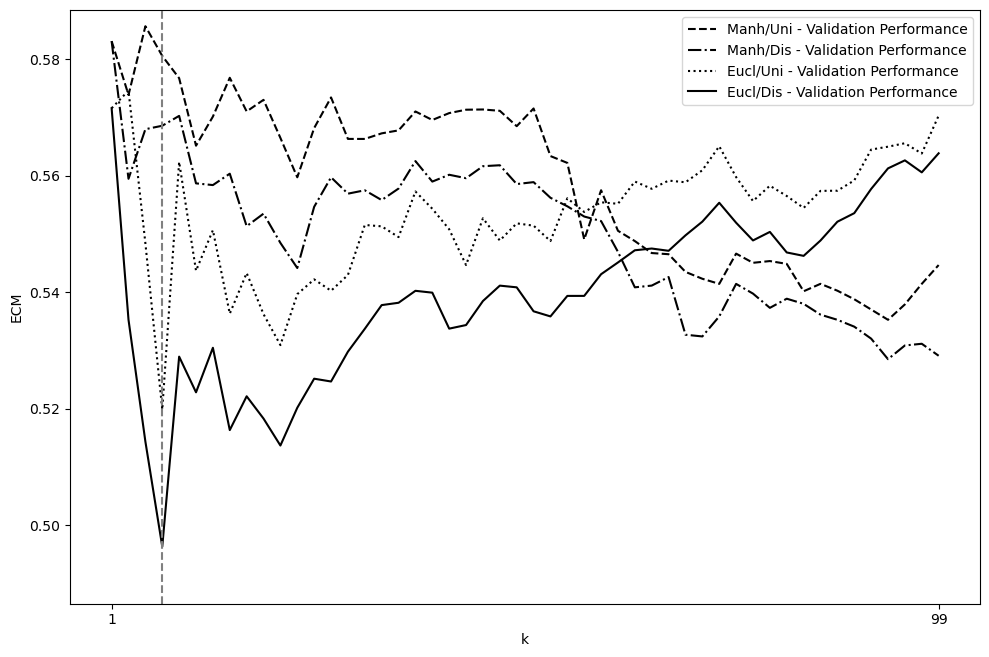

In [18]:
# Create a dictionary to store the combinations of hyperparameters to plot
param_combinations = {'p1_wu': (1, 'uniform'), 'p1_wd': (1, 'distance'), 'p2_wu': (2, 'uniform'), 'p2_wd': (2, 'distance')}

# Create a plot to show all four plots in one figure
fig, ax = plt.subplots(figsize=(10,6.67))

# Loop through the combinations and create a plot for each one
for i, (param_key, param_values) in enumerate(param_combinations.items()):
    # Create a mask for the rows in the CV results that match the current combination of hyperparameters
    mask = (knn_b_grid.cv_results_['param_knn__p'] == param_values[0]) & (knn_b_grid.cv_results_['param_knn__weights'] == param_values[1])

    # Get the average test scores for the current combination of hyperparameters
    test_scores = abs(knn_b_grid.cv_results_['mean_test_score'][mask])

    # Plot the test scores for the current combination of hyperparameters with different line styles
    if i == 0:
        ax.plot(test_scores, label='Manh/Uni - Validation Performance', linestyle='--',color='black')
    elif i == 1:
        ax.plot(test_scores, label='Manh/Dis - Validation Performance', linestyle='-.',color='black')
    elif i == 2:
        ax.plot(test_scores, label='Eucl/Uni - Validation Performance', linestyle=':',color='black')
    elif i == 3:
        ax.plot(test_scores, label='Eucl/Dis - Validation Performance', linestyle='-',color='black')

    # Set x-axis ticks and labels
    x_ticks = [0, len(knn_b_parameters['knn__n_neighbors'])-1]
    x_labels = [knn_b_parameters['knn__n_neighbors'][0], knn_b_parameters['knn__n_neighbors'][-1]]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)

    # Set y-axis range and label
    y_max = 0.58
    y_min = 0.495
    y_range = y_max - y_min
    ax.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)
    ax.set_ylabel('ECM')

    # Set x-axis label
    ax.set_xlabel('k')

    # Print the minimum validation ECM and the index of the best parameter
    min_score = round(min(test_scores), 3)
    best_param_idx = np.argmin(test_scores)
    best_param_value = knn_b_parameters['knn__n_neighbors'][best_param_idx]
    print(f'For {param_key}: Minimum validation error: {min_score}')
    print(f'For {param_key}: Best parameter value: {best_param_value}')

# Add vertical line at minimum validation error
ax.axvline(x=best_param_idx, linestyle='--', color='grey')

# Add legend to the plot
ax.legend(loc='best')

plt.tight_layout()
plt.show()
fig.savefig("knn_param.jpg", dpi=300, bbox_inches='tight')

In [20]:
# Pipeline steps
lgbm_b_steps = [
    ("over", SMOTE(random_state=42)), 
    ("gb", ltb.LGBMClassifier(random_state=42, n_jobs=-1)), 
]

# Pipeline
lgbm_b_pipeline = Pipeline(lgbm_b_steps)

# Set up the grid search parameters
lgbm_b_parameters = {'gb__num_leaves': [19, 77, 307, 1229, 4915, 19661],
                    'gb__max_depth': np.arange(5, 16, 2),
                    'gb__learning_rate': [0.01, 0.05, 0.1],
                     'gb__min_child_samples': [20, 50, 75, 100],
                    'gb__reg_lambda': [0.1, 1, 5, 10]}

# Setting up the GridSearch with CV
lgbm_b_grid = GridSearchCV(lgbm_b_pipeline, lgbm_b_parameters, cv=kf, verbose = 10, scoring=lgbm_scoring)

# Fit the grid search object to the training data
lgbm_b_grid.fit(X_b_train, y_b_train)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
[CV 1/5; 1/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 1/5; 1/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.984 total time=   2.0s
[CV 2/5; 1/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 2/5; 1/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.984 total time=   2.2s
[CV 3/5; 1/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 3/5; 1/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.985 total time=   2.1s
[CV 4/5; 1/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min

[CV 4/5; 6/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.985 total time=   2.0s
[CV 5/5; 6/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=1
[CV 5/5; 6/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.985 total time=   1.9s
[CV 1/5; 7/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 1/5; 7/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.984 total time=   1.7s
[CV 2/5; 7/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 2/5; 7/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.984 total tim

[CV 3/5; 12/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.985 total time=   1.7s
[CV 4/5; 12/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 4/5; 12/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.985 total time=   1.8s
[CV 5/5; 12/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 5/5; 12/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.985 total time=   1.8s
[CV 1/5; 13/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 1/5; 13/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=0.1

[CV 2/5; 18/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.984 total time=   1.8s
[CV 3/5; 18/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1
[CV 3/5; 18/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.985 total time=   1.9s
[CV 4/5; 18/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1
[CV 4/5; 18/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.985 total time=   1.9s
[CV 5/5; 18/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1
[CV 5/5; 18/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1;, s

[CV 1/5; 24/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.984 total time=   2.1s
[CV 2/5; 24/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=10
[CV 2/5; 24/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.984 total time=   2.2s
[CV 3/5; 24/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=10
[CV 3/5; 24/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.985 total time=   2.0s
[CV 4/5; 24/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=10
[CV 4/5; 24/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg

[CV 5/5; 29/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.985 total time=   1.8s
[CV 1/5; 30/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=1
[CV 1/5; 30/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.984 total time=   1.9s
[CV 2/5; 30/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=1
[CV 2/5; 30/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.984 total time=   1.8s
[CV 3/5; 30/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=1
[CV 3/5; 30/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.985 

[CV 4/5; 35/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.985 total time=   2.1s
[CV 5/5; 35/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 5/5; 35/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.985 total time=   2.0s
[CV 1/5; 36/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10
[CV 1/5; 36/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.984 total time=   2.1s
[CV 2/5; 36/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10
[CV 2/5; 36/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10;, scor

[CV 3/5; 41/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.985 total time=   1.6s
[CV 4/5; 41/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 4/5; 41/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.985 total time=   1.7s
[CV 5/5; 41/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 5/5; 41/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.985 total time=   1.9s
[CV 1/5; 42/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=1
[CV 1/5; 42/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_la

[CV 2/5; 47/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.984 total time=   2.4s
[CV 3/5; 47/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=5
[CV 3/5; 47/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.985 total time=   2.2s
[CV 4/5; 47/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=5
[CV 4/5; 47/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.985 total time=   2.0s
[CV 5/5; 47/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=5
[CV 5/5; 47/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambd

[CV 1/5; 53/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.984 total time=   2.1s
[CV 2/5; 53/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 2/5; 53/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.984 total time=   2.1s
[CV 3/5; 53/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 3/5; 53/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.985 total time=   2.0s
[CV 4/5; 53/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 4/5; 53/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1;, s

[CV 5/5; 58/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.985 total time=   1.9s
[CV 1/5; 59/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 1/5; 59/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.984 total time=   1.6s
[CV 2/5; 59/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 2/5; 59/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.984 total time=   1.5s
[CV 3/5; 59/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 3/5; 59/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0

[CV 4/5; 64/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.985 total time=   1.3s
[CV 5/5; 64/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 5/5; 64/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.985 total time=   1.4s
[CV 1/5; 65/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 1/5; 65/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.984 total time=   1.3s
[CV 2/5; 65/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 2/5; 65/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lam

[CV 3/5; 70/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.985 total time=   1.4s
[CV 4/5; 70/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1
[CV 4/5; 70/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.985 total time=   1.3s
[CV 5/5; 70/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1
[CV 5/5; 70/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.985 total time=   1.2s
[CV 1/5; 71/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=5
[CV 1/5; 71/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambd

[CV 2/5; 76/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.984 total time=   1.4s
[CV 3/5; 76/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 3/5; 76/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.985 total time=   1.2s
[CV 4/5; 76/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 76/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.985 total time=   1.3s
[CV 5/5; 76/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 5/5; 76/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, s

[CV 1/5; 82/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.984 total time=   1.4s
[CV 2/5; 82/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=1
[CV 2/5; 82/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.984 total time=   1.3s
[CV 3/5; 82/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=1
[CV 3/5; 82/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.985 total time=   1.5s
[CV 4/5; 82/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=1
[CV 4/5; 82/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=1;, s

[CV 5/5; 87/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.985 total time=   1.6s
[CV 1/5; 88/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 1/5; 88/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.984 total time=   1.5s
[CV 2/5; 88/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 2/5; 88/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.984 total time=   1.4s
[CV 3/5; 88/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 88/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_

[CV 3/5; 93/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.985 total time=   1.5s
[CV 4/5; 93/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 4/5; 93/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.985 total time=   1.5s
[CV 5/5; 93/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 5/5; 93/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.985 total time=   1.4s
[CV 1/5; 94/1728] START gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=1
[CV 1/5; 94/1728] END gb__learning_rate=0.01, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=196

[CV 2/5; 99/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.984 total time=   1.6s
[CV 3/5; 99/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 99/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.985 total time=   1.6s
[CV 4/5; 99/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 4/5; 99/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.985 total time=   1.6s
[CV 5/5; 99/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 5/5; 99/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.985 to

[CV 1/5; 105/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.984 total time=   1.8s
[CV 2/5; 105/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 2/5; 105/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.984 total time=   1.9s
[CV 3/5; 105/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 3/5; 105/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.985 total time=   2.1s
[CV 4/5; 105/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 4/5; 105/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_

[CV 5/5; 110/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.985 total time=   1.7s
[CV 1/5; 111/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 111/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.984 total time=   1.6s
[CV 2/5; 111/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 2/5; 111/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.984 total time=   1.8s
[CV 3/5; 111/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 3/5; 111/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambd

[CV 3/5; 116/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.985 total time=   1.7s
[CV 4/5; 116/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=10
[CV 4/5; 116/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.985 total time=   1.6s
[CV 5/5; 116/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=10
[CV 5/5; 116/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.985 total time=   1.6s
[CV 1/5; 117/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 1/5; 117/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19661, gb__

[CV 1/5; 122/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.984 total time=   1.4s
[CV 2/5; 122/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=1
[CV 2/5; 122/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.984 total time=   1.6s
[CV 3/5; 122/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=1
[CV 3/5; 122/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.985 total time=   1.8s
[CV 4/5; 122/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=1
[CV 4/5; 122/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=1;, score=-0

[CV 5/5; 127/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.985 total time=   1.5s
[CV 1/5; 128/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 1/5; 128/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.984 total time=   1.5s
[CV 2/5; 128/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 2/5; 128/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.984 total time=   1.6s
[CV 3/5; 128/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 3/5; 128/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, sc

[CV 4/5; 133/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.985 total time=   2.0s
[CV 5/5; 133/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 5/5; 133/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.985 total time=   1.7s
[CV 1/5; 134/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=1
[CV 1/5; 134/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.984 total time=   1.5s
[CV 2/5; 134/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=1
[CV 2/5; 134/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg

[CV 2/5; 139/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.984 total time=   1.6s
[CV 3/5; 139/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=5
[CV 3/5; 139/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.985 total time=   1.7s
[CV 4/5; 139/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=5
[CV 4/5; 139/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.985 total time=   1.5s
[CV 5/5; 139/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=5
[CV 5/5; 139/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambd

[CV 5/5; 144/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.985 total time=   1.5s
[CV 1/5; 145/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 1/5; 145/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.984 total time=   1.5s
[CV 2/5; 145/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 2/5; 145/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.984 total time=   1.4s
[CV 3/5; 145/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 3/5; 145/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambd

[CV 4/5; 150/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.985 total time=   1.4s
[CV 5/5; 150/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=1
[CV 5/5; 150/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.985 total time=   1.4s
[CV 1/5; 151/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5
[CV 1/5; 151/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.984 total time=   1.3s
[CV 2/5; 151/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5
[CV 2/5; 151/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5;, score=-0

[CV 3/5; 156/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.985 total time=   1.5s
[CV 4/5; 156/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=10
[CV 4/5; 156/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.985 total time=   1.4s
[CV 5/5; 156/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=10
[CV 5/5; 156/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.985 total time=   1.4s
[CV 1/5; 157/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 1/5; 157/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lam

[CV 1/5; 162/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.984 total time=   1.4s
[CV 2/5; 162/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=1
[CV 2/5; 162/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.984 total time=   1.5s
[CV 3/5; 162/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=1
[CV 3/5; 162/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.985 total time=   1.5s
[CV 4/5; 162/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=1
[CV 4/5; 162/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambd

[CV 4/5; 167/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.985 total time=   1.3s
[CV 5/5; 167/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=5
[CV 5/5; 167/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.985 total time=   1.4s
[CV 1/5; 168/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=10
[CV 1/5; 168/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.984 total time=   1.4s
[CV 2/5; 168/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=10
[CV 2/5; 168/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19661, gb_

[CV 3/5; 173/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.985 total time=   1.4s
[CV 4/5; 173/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 4/5; 173/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.985 total time=   1.4s
[CV 5/5; 173/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 5/5; 173/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.985 total time=   1.3s
[CV 1/5; 174/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1
[CV 1/5; 174/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_la

[CV 2/5; 179/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.984 total time=   1.4s
[CV 3/5; 179/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 3/5; 179/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.985 total time=   1.4s
[CV 4/5; 179/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 179/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.985 total time=   1.3s
[CV 5/5; 179/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 5/5; 179/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambd

[CV 5/5; 184/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.985 total time=   1.4s
[CV 1/5; 185/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 1/5; 185/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.984 total time=   1.5s
[CV 2/5; 185/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 2/5; 185/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.984 total time=   1.4s
[CV 3/5; 185/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 3/5; 185/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=4

[CV 3/5; 190/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.985 total time=   1.4s
[CV 4/5; 190/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=1
[CV 4/5; 190/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.985 total time=   1.3s
[CV 5/5; 190/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=1
[CV 5/5; 190/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.985 total time=   1.3s
[CV 1/5; 191/1728] START gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=5
[CV 1/5; 191/1728] END gb__learning_rate=0.01, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19661,

[CV 1/5; 196/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.984 total time=   1.6s
[CV 2/5; 196/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=10
[CV 2/5; 196/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.984 total time=   1.6s
[CV 3/5; 196/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=10
[CV 3/5; 196/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.985 total time=   1.7s
[CV 4/5; 196/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 196/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=10;, s

[CV 5/5; 201/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.985 total time=   2.1s
[CV 1/5; 202/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=1
[CV 1/5; 202/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.984 total time=   2.1s
[CV 2/5; 202/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=1
[CV 2/5; 202/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.984 total time=   2.5s
[CV 3/5; 202/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=1
[CV 3/5; 202/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=1;,

[CV 4/5; 207/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.985 total time=   2.1s
[CV 5/5; 207/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 207/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.985 total time=   2.0s
[CV 1/5; 208/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10
[CV 1/5; 208/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.984 total time=   1.8s
[CV 2/5; 208/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10
[CV 2/5; 208/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_la

[CV 2/5; 213/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.984 total time=   2.5s
[CV 3/5; 213/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 3/5; 213/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.985 total time=   2.2s
[CV 4/5; 213/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 4/5; 213/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.985 total time=   2.4s
[CV 5/5; 213/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 5/5; 213/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1

[CV 5/5; 218/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.985 total time=   1.6s
[CV 1/5; 219/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 219/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.984 total time=   1.6s
[CV 2/5; 219/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 2/5; 219/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.984 total time=   1.7s
[CV 3/5; 219/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 219/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0

[CV 4/5; 224/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.985 total time=   1.7s
[CV 5/5; 224/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 224/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.985 total time=   1.7s
[CV 1/5; 225/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 1/5; 225/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.984 total time=   1.9s
[CV 2/5; 225/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 2/5; 225/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda

[CV 3/5; 230/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.985 total time=   2.3s
[CV 4/5; 230/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=1
[CV 4/5; 230/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.985 total time=   1.8s
[CV 5/5; 230/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=1
[CV 5/5; 230/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.985 total time=   1.9s
[CV 1/5; 231/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 231/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambd

[CV 1/5; 236/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.984 total time=   1.9s
[CV 2/5; 236/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10
[CV 2/5; 236/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.984 total time=   1.8s
[CV 3/5; 236/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10
[CV 3/5; 236/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.985 total time=   1.7s
[CV 4/5; 236/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10
[CV 4/5; 236/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg

[CV 4/5; 241/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.985 total time=   1.5s
[CV 5/5; 241/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 5/5; 241/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.985 total time=   1.6s
[CV 1/5; 242/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=1
[CV 1/5; 242/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.984 total time=   1.7s
[CV 2/5; 242/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=1
[CV 2/5; 242/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=1;, sc

[CV 3/5; 247/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.985 total time=   1.7s
[CV 4/5; 247/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5
[CV 4/5; 247/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.985 total time=   1.5s
[CV 5/5; 247/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5
[CV 5/5; 247/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.985 total time=   1.8s
[CV 1/5; 248/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10
[CV 1/5; 248/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=

[CV 2/5; 253/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.984 total time=   1.8s
[CV 3/5; 253/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 3/5; 253/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.985 total time=   1.8s
[CV 4/5; 253/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 4/5; 253/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.985 total time=   2.0s
[CV 5/5; 253/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 5/5; 253/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, g

[CV 5/5; 258/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.985 total time=   1.9s
[CV 1/5; 259/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=5
[CV 1/5; 259/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.984 total time=   1.6s
[CV 2/5; 259/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=5
[CV 2/5; 259/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.984 total time=   1.9s
[CV 3/5; 259/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=5
[CV 3/5; 259/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambd

[CV 3/5; 264/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.985 total time=   1.4s
[CV 4/5; 264/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=10
[CV 4/5; 264/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.985 total time=   1.4s
[CV 5/5; 264/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=10
[CV 5/5; 264/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.985 total time=   1.5s
[CV 1/5; 265/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 1/5; 265/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19, gb_

[CV 2/5; 270/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.984 total time=   1.4s
[CV 3/5; 270/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1
[CV 3/5; 270/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.985 total time=   1.4s
[CV 4/5; 270/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1
[CV 4/5; 270/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.985 total time=   1.4s
[CV 5/5; 270/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1
[CV 5/5; 270/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1;, s

[CV 1/5; 276/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.984 total time=   1.3s
[CV 2/5; 276/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 2/5; 276/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.984 total time=   1.3s
[CV 3/5; 276/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 3/5; 276/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.985 total time=   1.3s
[CV 4/5; 276/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 4/5; 276/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg

[CV 4/5; 281/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.985 total time=   1.5s
[CV 5/5; 281/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 5/5; 281/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.985 total time=   1.6s
[CV 1/5; 282/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=1
[CV 1/5; 282/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.984 total time=   1.4s
[CV 2/5; 282/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=1
[CV 2/5; 282/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=4915, 

[CV 2/5; 287/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.984 total time=   1.5s
[CV 3/5; 287/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=5
[CV 3/5; 287/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.985 total time=   1.6s
[CV 4/5; 287/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=5
[CV 4/5; 287/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.985 total time=   1.4s
[CV 5/5; 287/1728] START gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=5
[CV 5/5; 287/1728] END gb__learning_rate=0.01, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19661,

[CV 5/5; 292/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.985 total time=   1.4s
[CV 1/5; 293/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 1/5; 293/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.984 total time=   2.0s
[CV 2/5; 293/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 2/5; 293/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.984 total time=   1.9s
[CV 3/5; 293/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 3/5; 293/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_l

[CV 4/5; 298/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.985 total time=   1.8s
[CV 5/5; 298/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=1
[CV 5/5; 298/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.985 total time=   1.9s
[CV 1/5; 299/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=5
[CV 1/5; 299/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.984 total time=   1.7s
[CV 2/5; 299/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=5
[CV 2/5; 299/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambd

[CV 2/5; 304/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.984 total time=   1.9s
[CV 3/5; 304/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 304/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.985 total time=   2.0s
[CV 4/5; 304/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 304/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.985 total time=   1.8s
[CV 5/5; 304/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10
[CV 5/5; 304/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=1229, 

[CV 5/5; 309/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.985 total time=   2.3s
[CV 1/5; 310/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=1
[CV 1/5; 310/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.984 total time=   2.0s
[CV 2/5; 310/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=1
[CV 2/5; 310/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.984 total time=   2.2s
[CV 3/5; 310/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=1
[CV 3/5; 310/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=1966

[CV 3/5; 315/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.985 total time=   1.4s
[CV 4/5; 315/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 4/5; 315/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.985 total time=   1.5s
[CV 5/5; 315/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 5/5; 315/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.985 total time=   1.5s
[CV 1/5; 316/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10
[CV 1/5; 316/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10;,

[CV 2/5; 321/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.984 total time=   2.7s
[CV 3/5; 321/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 3/5; 321/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.985 total time=   2.5s
[CV 4/5; 321/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 4/5; 321/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.985 total time=   2.2s
[CV 5/5; 321/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 5/5; 321/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, g

[CV 5/5; 326/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.985 total time=   1.6s
[CV 1/5; 327/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 327/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.984 total time=   1.6s
[CV 2/5; 327/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 2/5; 327/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.984 total time=   1.7s
[CV 3/5; 327/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 3/5; 327/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__re

[CV 3/5; 332/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.985 total time=   1.6s
[CV 4/5; 332/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10
[CV 4/5; 332/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.985 total time=   1.7s
[CV 5/5; 332/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10
[CV 5/5; 332/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.985 total time=   1.7s
[CV 1/5; 333/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 1/5; 333/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1966

[CV 1/5; 338/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.984 total time=   1.4s
[CV 2/5; 338/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=1
[CV 2/5; 338/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.984 total time=   1.4s
[CV 3/5; 338/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=1
[CV 3/5; 338/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.985 total time=   1.4s
[CV 4/5; 338/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=1
[CV 4/5; 338/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=1;, s

[CV 5/5; 343/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.985 total time=   1.4s
[CV 1/5; 344/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10
[CV 1/5; 344/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.984 total time=   1.3s
[CV 2/5; 344/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10
[CV 2/5; 344/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.984 total time=   1.5s
[CV 3/5; 344/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10
[CV 3/5; 344/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=

[CV 3/5; 349/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.985 total time=   1.7s
[CV 4/5; 349/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 4/5; 349/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.985 total time=   1.8s
[CV 5/5; 349/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 5/5; 349/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.985 total time=   1.8s
[CV 1/5; 350/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=1
[CV 1/5; 350/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=12

[CV 1/5; 355/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.984 total time=   1.9s
[CV 2/5; 355/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=5
[CV 2/5; 355/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.984 total time=   1.8s
[CV 3/5; 355/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=5
[CV 3/5; 355/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.985 total time=   1.8s
[CV 4/5; 355/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=5
[CV 4/5; 355/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=4915, gb__re

[CV 4/5; 360/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.985 total time=   1.6s
[CV 5/5; 360/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=10
[CV 5/5; 360/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.985 total time=   1.7s
[CV 1/5; 361/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 1/5; 361/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.984 total time=   1.5s
[CV 2/5; 361/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 2/5; 361/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19

[CV 2/5; 366/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.984 total time=   1.5s
[CV 3/5; 366/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1
[CV 3/5; 366/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.985 total time=   1.5s
[CV 4/5; 366/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1
[CV 4/5; 366/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.985 total time=   1.5s
[CV 5/5; 366/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1
[CV 5/5; 366/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambd

[CV 5/5; 371/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.985 total time=   1.4s
[CV 1/5; 372/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 1/5; 372/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.984 total time=   1.6s
[CV 2/5; 372/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 2/5; 372/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.984 total time=   1.4s
[CV 3/5; 372/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 3/5; 372/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=307, g

[CV 3/5; 377/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.985 total time=   1.8s
[CV 4/5; 377/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 4/5; 377/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.985 total time=   2.0s
[CV 5/5; 377/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 5/5; 377/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.985 total time=   1.7s
[CV 1/5; 378/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=1
[CV 1/5; 378/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_le

[CV 1/5; 383/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.984 total time=   1.5s
[CV 2/5; 383/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=5
[CV 2/5; 383/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.984 total time=   1.8s
[CV 3/5; 383/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=5
[CV 3/5; 383/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.985 total time=   1.7s
[CV 4/5; 383/1728] START gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=5
[CV 4/5; 383/1728] END gb__learning_rate=0.01, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves

[CV 4/5; 388/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.985 total time=   1.6s
[CV 5/5; 388/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=10
[CV 5/5; 388/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.985 total time=   1.6s
[CV 1/5; 389/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 1/5; 389/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.984 total time=   2.1s
[CV 2/5; 389/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 2/5; 389/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lam

[CV 3/5; 394/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.985 total time=   2.0s
[CV 4/5; 394/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=1
[CV 4/5; 394/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.985 total time=   2.0s
[CV 5/5; 394/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=1
[CV 5/5; 394/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.985 total time=   1.8s
[CV 1/5; 395/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=5
[CV 1/5; 395/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambd

[CV 1/5; 400/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.984 total time=   1.8s
[CV 2/5; 400/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10
[CV 2/5; 400/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.984 total time=   2.0s
[CV 3/5; 400/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 400/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.985 total time=   2.0s
[CV 4/5; 400/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 400/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=1229, 

[CV 4/5; 405/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.985 total time=   3.7s
[CV 5/5; 405/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 5/5; 405/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.985 total time=   3.9s
[CV 1/5; 406/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=1
[CV 1/5; 406/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.984 total time=   3.7s
[CV 2/5; 406/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=1
[CV 2/5; 406/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=

[CV 2/5; 411/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.984 total time=   1.6s
[CV 3/5; 411/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 411/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.985 total time=   1.8s
[CV 4/5; 411/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 4/5; 411/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.985 total time=   1.4s
[CV 5/5; 411/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 5/5; 411/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, s

[CV 1/5; 417/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.984 total time=   1.8s
[CV 2/5; 417/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 2/5; 417/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.984 total time=   2.0s
[CV 3/5; 417/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 3/5; 417/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.985 total time=   2.0s
[CV 4/5; 417/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 4/5; 417/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=307, g

[CV 4/5; 422/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.985 total time=   2.0s
[CV 5/5; 422/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=1
[CV 5/5; 422/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.985 total time=   2.2s
[CV 1/5; 423/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 423/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.984 total time=   2.0s
[CV 2/5; 423/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 2/5; 423/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=1229, gb__re

[CV 2/5; 428/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.984 total time=   2.7s
[CV 3/5; 428/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10
[CV 3/5; 428/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.985 total time=   2.5s
[CV 4/5; 428/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10
[CV 4/5; 428/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.985 total time=   2.2s
[CV 5/5; 428/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10
[CV 5/5; 428/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=4915, 

[CV 5/5; 433/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.985 total time=   1.5s
[CV 1/5; 434/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=1
[CV 1/5; 434/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.984 total time=   1.5s
[CV 2/5; 434/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=1
[CV 2/5; 434/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.984 total time=   1.5s
[CV 3/5; 434/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=1
[CV 3/5; 434/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=1;,

[CV 4/5; 439/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.985 total time=   1.9s
[CV 5/5; 439/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5
[CV 5/5; 439/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.985 total time=   1.7s
[CV 1/5; 440/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10
[CV 1/5; 440/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.984 total time=   1.7s
[CV 2/5; 440/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10
[CV 2/5; 440/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10

[CV 2/5; 445/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.984 total time=   2.2s
[CV 3/5; 445/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 3/5; 445/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.985 total time=   2.2s
[CV 4/5; 445/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 4/5; 445/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.985 total time=   2.2s
[CV 5/5; 445/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 5/5; 445/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=

[CV 5/5; 450/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.985 total time=   2.3s
[CV 1/5; 451/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=5
[CV 1/5; 451/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.984 total time=   2.0s
[CV 2/5; 451/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=5
[CV 2/5; 451/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.984 total time=   2.3s
[CV 3/5; 451/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=5
[CV 3/5; 451/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=4915, gb__re

[CV 3/5; 456/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.985 total time=   3.6s
[CV 4/5; 456/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=10
[CV 4/5; 456/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.985 total time=   3.1s
[CV 5/5; 456/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=10
[CV 5/5; 456/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.985 total time=   3.1s
[CV 1/5; 457/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 1/5; 457/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=

[CV 1/5; 462/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.984 total time=   1.5s
[CV 2/5; 462/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1
[CV 2/5; 462/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.984 total time=   1.6s
[CV 3/5; 462/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1
[CV 3/5; 462/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.985 total time=   2.1s
[CV 4/5; 462/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1
[CV 4/5; 462/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambd

[CV 4/5; 467/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.985 total time=   1.5s
[CV 5/5; 467/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 5/5; 467/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.985 total time=   1.6s
[CV 1/5; 468/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 1/5; 468/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.984 total time=   1.5s
[CV 2/5; 468/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 2/5; 468/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=307, gb_

[CV 2/5; 473/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.984 total time=   2.9s
[CV 3/5; 473/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 3/5; 473/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.985 total time=   2.4s
[CV 4/5; 473/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 4/5; 473/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.985 total time=   2.4s
[CV 5/5; 473/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 5/5; 473/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_

[CV 5/5; 478/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.985 total time=   3.3s
[CV 1/5; 479/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=5
[CV 1/5; 479/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.984 total time=   3.4s
[CV 2/5; 479/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=5
[CV 2/5; 479/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.984 total time=   3.1s
[CV 3/5; 479/1728] START gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=5
[CV 3/5; 479/1728] END gb__learning_rate=0.01, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves

[CV 3/5; 484/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.985 total time=   1.6s
[CV 4/5; 484/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 484/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.985 total time=   1.6s
[CV 5/5; 484/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=10
[CV 5/5; 484/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.985 total time=   1.6s
[CV 1/5; 485/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 1/5; 485/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambd

[CV 2/5; 490/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.984 total time=   2.2s
[CV 3/5; 490/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=1
[CV 3/5; 490/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.985 total time=   2.1s
[CV 4/5; 490/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=1
[CV 4/5; 490/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.985 total time=   2.0s
[CV 5/5; 490/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=1
[CV 5/5; 490/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambd

[CV 5/5; 495/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.985 total time=   2.1s
[CV 1/5; 496/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10
[CV 1/5; 496/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.984 total time=   1.9s
[CV 2/5; 496/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10
[CV 2/5; 496/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.984 total time=   2.0s
[CV 3/5; 496/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 496/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=1229, g

[CV 3/5; 501/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.985 total time=   8.7s
[CV 4/5; 501/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 4/5; 501/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.985 total time=   9.6s
[CV 5/5; 501/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 5/5; 501/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.985 total time=   9.3s
[CV 1/5; 502/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=1
[CV 1/5; 502/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=20, gb__num_lea

[CV 1/5; 507/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.984 total time=   1.5s
[CV 2/5; 507/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 2/5; 507/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.984 total time=   1.6s
[CV 3/5; 507/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 507/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.985 total time=   1.7s
[CV 4/5; 507/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 4/5; 507/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, s

[CV 5/5; 512/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.985 total time=   1.8s
[CV 1/5; 513/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 1/5; 513/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.984 total time=   2.0s
[CV 2/5; 513/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 2/5; 513/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.984 total time=   2.2s
[CV 3/5; 513/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 3/5; 513/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=307, gb_

[CV 3/5; 518/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.985 total time=   2.1s
[CV 4/5; 518/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=1
[CV 4/5; 518/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.985 total time=   1.9s
[CV 5/5; 518/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=1
[CV 5/5; 518/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.985 total time=   2.1s
[CV 1/5; 519/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 519/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=1229, gb__re

[CV 1/5; 524/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.984 total time=   2.7s
[CV 2/5; 524/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10
[CV 2/5; 524/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.984 total time=   2.7s
[CV 3/5; 524/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10
[CV 3/5; 524/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.985 total time=   2.7s
[CV 4/5; 524/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10
[CV 4/5; 524/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=4915, 

[CV 4/5; 529/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.985 total time=   1.6s
[CV 5/5; 529/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 5/5; 529/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.985 total time=   1.5s
[CV 1/5; 530/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=1
[CV 1/5; 530/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.984 total time=   1.5s
[CV 2/5; 530/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=1
[CV 2/5; 530/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda

[CV 3/5; 535/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.985 total time=   1.3s
[CV 4/5; 535/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5
[CV 4/5; 535/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.985 total time=   1.3s
[CV 5/5; 535/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5
[CV 5/5; 535/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.985 total time=   1.3s
[CV 1/5; 536/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10
[CV 1/5; 536/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;,

[CV 1/5; 541/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.984 total time=   1.6s
[CV 2/5; 541/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 2/5; 541/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.984 total time=   1.6s
[CV 3/5; 541/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 3/5; 541/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.985 total time=   1.9s
[CV 4/5; 541/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 4/5; 541/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=

[CV 4/5; 546/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.985 total time=   2.5s
[CV 5/5; 546/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=1
[CV 5/5; 546/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.985 total time=   2.0s
[CV 1/5; 547/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=5
[CV 1/5; 547/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.984 total time=   2.2s
[CV 2/5; 547/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=5
[CV 2/5; 547/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=4915, gb__re

[CV 2/5; 552/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.984 total time=  10.8s
[CV 3/5; 552/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=10
[CV 3/5; 552/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.985 total time=  10.9s
[CV 4/5; 552/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=10
[CV 4/5; 552/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.985 total time=  12.8s
[CV 5/5; 552/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=10
[CV 5/5; 552/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=

[CV 5/5; 557/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.985 total time=   1.4s
[CV 1/5; 558/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1
[CV 1/5; 558/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.984 total time=   1.3s
[CV 2/5; 558/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1
[CV 2/5; 558/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.984 total time=   1.6s
[CV 3/5; 558/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1
[CV 3/5; 558/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lam

[CV 3/5; 563/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.985 total time=   1.8s
[CV 4/5; 563/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 563/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.985 total time=   2.1s
[CV 5/5; 563/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5
[CV 5/5; 563/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.985 total time=   2.4s
[CV 1/5; 564/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 1/5; 564/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=307, gb__r

[CV 1/5; 569/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.984 total time=   3.5s
[CV 2/5; 569/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 2/5; 569/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.984 total time=   3.4s
[CV 3/5; 569/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 3/5; 569/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.985 total time=   3.8s
[CV 4/5; 569/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 4/5; 569/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_

[CV 4/5; 574/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.985 total time=  17.9s
[CV 5/5; 574/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=1
[CV 5/5; 574/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.985 total time=  18.6s
[CV 1/5; 575/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=5
[CV 1/5; 575/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.984 total time=  17.0s
[CV 2/5; 575/1728] START gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=5
[CV 2/5; 575/1728] END gb__learning_rate=0.01, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves

[CV 2/5; 580/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.497 total time=   2.3s
[CV 3/5; 580/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=10
[CV 3/5; 580/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.477 total time=   2.5s
[CV 4/5; 580/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 580/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.540 total time=   2.6s
[CV 5/5; 580/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=10
[CV 5/5; 580/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=10;, s

[CV 1/5; 586/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.506 total time=   2.0s
[CV 2/5; 586/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=1
[CV 2/5; 586/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.444 total time=   2.2s
[CV 3/5; 586/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=1
[CV 3/5; 586/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.441 total time=   2.3s
[CV 4/5; 586/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=1
[CV 4/5; 586/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=1;, s

[CV 5/5; 591/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.629 total time=   1.7s
[CV 1/5; 592/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10
[CV 1/5; 592/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.556 total time=   1.7s
[CV 2/5; 592/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10
[CV 2/5; 592/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.497 total time=   1.7s
[CV 3/5; 592/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 592/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_

[CV 3/5; 597/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.424 total time=   1.7s
[CV 4/5; 597/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 4/5; 597/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.426 total time=   1.8s
[CV 5/5; 597/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 5/5; 597/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.602 total time=   1.9s
[CV 1/5; 598/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=1
[CV 1/5; 598/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=196

[CV 1/5; 603/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.550 total time=   1.4s
[CV 2/5; 603/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 2/5; 603/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.484 total time=   1.7s
[CV 3/5; 603/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 603/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.447 total time=   1.8s
[CV 4/5; 603/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5
[CV 4/5; 603/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=5;, score=-0

[CV 5/5; 608/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.633 total time=   1.6s
[CV 1/5; 609/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 1/5; 609/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.518 total time=   1.7s
[CV 2/5; 609/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 2/5; 609/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.517 total time=   1.7s
[CV 3/5; 609/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 3/5; 609/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_la

[CV 4/5; 614/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.546 total time=   2.0s
[CV 5/5; 614/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=1
[CV 5/5; 614/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.621 total time=   1.7s
[CV 1/5; 615/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 615/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.555 total time=   1.8s
[CV 2/5; 615/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 2/5; 615/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambd

[CV 2/5; 620/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.502 total time=   1.7s
[CV 3/5; 620/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10
[CV 3/5; 620/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.442 total time=   1.6s
[CV 4/5; 620/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10
[CV 4/5; 620/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.517 total time=   1.7s
[CV 5/5; 620/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=10
[CV 5/5; 620/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg

[CV 5/5; 625/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.627 total time=   1.5s
[CV 1/5; 626/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=1
[CV 1/5; 626/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.531 total time=   1.6s
[CV 2/5; 626/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=1
[CV 2/5; 626/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.511 total time=   1.7s
[CV 3/5; 626/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=1
[CV 3/5; 626/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=1;, score=

[CV 4/5; 631/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.514 total time=   1.6s
[CV 5/5; 631/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5
[CV 5/5; 631/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.651 total time=   1.5s
[CV 1/5; 632/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10
[CV 1/5; 632/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.584 total time=   1.6s
[CV 2/5; 632/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10
[CV 2/5; 632/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, scor

[CV 3/5; 637/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.474 total time=   1.8s
[CV 4/5; 637/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 4/5; 637/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.540 total time=   1.7s
[CV 5/5; 637/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 5/5; 637/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.623 total time=   1.6s
[CV 1/5; 638/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=1
[CV 1/5; 638/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb_

[CV 1/5; 643/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.562 total time=   1.5s
[CV 2/5; 643/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=5
[CV 2/5; 643/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.494 total time=   1.8s
[CV 3/5; 643/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=5
[CV 3/5; 643/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.425 total time=   1.7s
[CV 4/5; 643/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=5
[CV 4/5; 643/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambd

[CV 4/5; 648/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.567 total time=   1.6s
[CV 5/5; 648/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=10
[CV 5/5; 648/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.656 total time=   1.8s
[CV 1/5; 649/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 1/5; 649/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.524 total time=   1.8s
[CV 2/5; 649/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 2/5; 649/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19, gb__r

[CV 3/5; 654/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.413 total time=   1.4s
[CV 4/5; 654/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1
[CV 4/5; 654/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.498 total time=   1.7s
[CV 5/5; 654/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1
[CV 5/5; 654/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.645 total time=   1.7s
[CV 1/5; 655/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 1/5; 655/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, s

[CV 2/5; 660/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.480 total time=   1.6s
[CV 3/5; 660/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 3/5; 660/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.436 total time=   1.6s
[CV 4/5; 660/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 4/5; 660/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.551 total time=   1.6s
[CV 5/5; 660/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10
[CV 5/5; 660/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=307, gb__reg

[CV 5/5; 665/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.639 total time=   1.6s
[CV 1/5; 666/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=1
[CV 1/5; 666/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.545 total time=   1.6s
[CV 2/5; 666/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=1
[CV 2/5; 666/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.518 total time=   1.7s
[CV 3/5; 666/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=1
[CV 3/5; 666/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=4915, gb__

[CV 3/5; 671/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.399 total time=   1.6s
[CV 4/5; 671/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=5
[CV 4/5; 671/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.529 total time=   1.5s
[CV 5/5; 671/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=5
[CV 5/5; 671/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.677 total time=   1.7s
[CV 1/5; 672/1728] START gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=10
[CV 1/5; 672/1728] END gb__learning_rate=0.05, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19661

[CV 2/5; 677/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.553 total time=   2.1s
[CV 3/5; 677/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 3/5; 677/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.436 total time=   2.3s
[CV 4/5; 677/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 4/5; 677/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.476 total time=   2.2s
[CV 5/5; 677/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 5/5; 677/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=

[CV 1/5; 683/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.455 total time=   2.0s
[CV 2/5; 683/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=5
[CV 2/5; 683/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.425 total time=   1.9s
[CV 3/5; 683/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=5
[CV 3/5; 683/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.493 total time=   1.9s
[CV 4/5; 683/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 683/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=5;, s

[CV 4/5; 688/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.473 total time=   2.3s
[CV 5/5; 688/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10
[CV 5/5; 688/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.603 total time=   2.3s
[CV 1/5; 689/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 1/5; 689/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.458 total time=   2.3s
[CV 2/5; 689/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 2/5; 689/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=4915, gb__

[CV 2/5; 694/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.494 total time=   2.1s
[CV 3/5; 694/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=1
[CV 3/5; 694/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.425 total time=   2.0s
[CV 4/5; 694/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=1
[CV 4/5; 694/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.485 total time=   2.1s
[CV 5/5; 694/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=1
[CV 5/5; 694/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19661, gb__re

[CV 1/5; 700/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.512 total time=   1.9s
[CV 2/5; 700/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10
[CV 2/5; 700/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.436 total time=   1.9s
[CV 3/5; 700/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10
[CV 3/5; 700/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.469 total time=   1.6s
[CV 4/5; 700/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 700/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10;, s

[CV 5/5; 705/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.574 total time=   2.0s
[CV 1/5; 706/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=1
[CV 1/5; 706/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.458 total time=   1.9s
[CV 2/5; 706/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=1
[CV 2/5; 706/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.493 total time=   2.0s
[CV 3/5; 706/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=1
[CV 3/5; 706/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=1;,

[CV 4/5; 711/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.541 total time=   1.8s
[CV 5/5; 711/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 711/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.577 total time=   1.9s
[CV 1/5; 712/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10
[CV 1/5; 712/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.478 total time=   2.6s
[CV 2/5; 712/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10
[CV 2/5; 712/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_la

[CV 2/5; 717/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.521 total time=   2.0s
[CV 3/5; 717/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 3/5; 717/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.429 total time=   2.0s
[CV 4/5; 717/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 4/5; 717/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.548 total time=   2.2s
[CV 5/5; 717/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 5/5; 717/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=1

[CV 5/5; 722/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.563 total time=   1.8s
[CV 1/5; 723/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 723/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.496 total time=   1.9s
[CV 2/5; 723/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5
[CV 2/5; 723/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.431 total time=   2.2s
[CV 3/5; 723/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 723/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5;, score=-0

[CV 4/5; 728/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.532 total time=   1.7s
[CV 5/5; 728/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 728/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.620 total time=   1.9s
[CV 1/5; 729/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 1/5; 729/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.480 total time=   2.1s
[CV 2/5; 729/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 2/5; 729/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda

[CV 3/5; 734/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.417 total time=   1.8s
[CV 4/5; 734/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=1
[CV 4/5; 734/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.555 total time=   1.7s
[CV 5/5; 734/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=1
[CV 5/5; 734/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.566 total time=   1.8s
[CV 1/5; 735/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 735/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambd

[CV 1/5; 740/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.520 total time=   1.8s
[CV 2/5; 740/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=10
[CV 2/5; 740/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.453 total time=   1.8s
[CV 3/5; 740/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=10
[CV 3/5; 740/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.480 total time=   1.8s
[CV 4/5; 740/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=10
[CV 4/5; 740/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg

[CV 4/5; 745/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.534 total time=   1.8s
[CV 5/5; 745/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 5/5; 745/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.571 total time=   1.9s
[CV 1/5; 746/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=1
[CV 1/5; 746/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.476 total time=   1.7s
[CV 2/5; 746/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=1
[CV 2/5; 746/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda

[CV 3/5; 751/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.418 total time=   1.8s
[CV 4/5; 751/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 4/5; 751/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.502 total time=   2.2s
[CV 5/5; 751/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 5/5; 751/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.610 total time=   1.8s
[CV 1/5; 752/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=10
[CV 1/5; 752/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=10;,

[CV 1/5; 757/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.465 total time=   2.0s
[CV 2/5; 757/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 2/5; 757/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.493 total time=   1.9s
[CV 3/5; 757/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 3/5; 757/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.458 total time=   1.9s
[CV 4/5; 757/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 4/5; 757/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=

[CV 4/5; 762/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.526 total time=   1.4s
[CV 5/5; 762/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=1
[CV 5/5; 762/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.579 total time=   1.4s
[CV 1/5; 763/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=5
[CV 1/5; 763/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.512 total time=   1.4s
[CV 2/5; 763/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=5
[CV 2/5; 763/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=4915, gb__re

[CV 2/5; 768/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.422 total time=   1.3s
[CV 3/5; 768/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=10
[CV 3/5; 768/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.489 total time=   1.3s
[CV 4/5; 768/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=10
[CV 4/5; 768/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.473 total time=   1.3s
[CV 5/5; 768/1728] START gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=10
[CV 5/5; 768/1728] END gb__learning_rate=0.05, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=

[CV 1/5; 774/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.412 total time=   2.0s
[CV 2/5; 774/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=1
[CV 2/5; 774/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.540 total time=   2.0s
[CV 3/5; 774/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=1
[CV 3/5; 774/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.483 total time=   2.1s
[CV 4/5; 774/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=1
[CV 4/5; 774/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=1;, score=-0

[CV 5/5; 779/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.601 total time=   2.0s
[CV 1/5; 780/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 1/5; 780/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.447 total time=   2.0s
[CV 2/5; 780/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 2/5; 780/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.433 total time=   2.1s
[CV 3/5; 780/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 3/5; 780/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=

[CV 3/5; 785/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.488 total time=   2.4s
[CV 4/5; 785/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 4/5; 785/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.494 total time=   2.3s
[CV 5/5; 785/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 5/5; 785/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.624 total time=   2.6s
[CV 1/5; 786/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1
[CV 1/5; 786/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=4915, gb_

[CV 1/5; 791/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.482 total time=   2.3s
[CV 2/5; 791/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=5
[CV 2/5; 791/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.452 total time=   2.3s
[CV 3/5; 791/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=5
[CV 3/5; 791/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.508 total time=   2.3s
[CV 4/5; 791/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=5
[CV 4/5; 791/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19661, gb__re

[CV 5/5; 796/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.575 total time=   1.8s
[CV 1/5; 797/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 1/5; 797/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.422 total time=   2.1s
[CV 2/5; 797/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 2/5; 797/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.509 total time=   2.0s
[CV 3/5; 797/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 3/5; 797/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0

[CV 4/5; 802/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.535 total time=   1.8s
[CV 5/5; 802/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=1
[CV 5/5; 802/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.597 total time=   1.8s
[CV 1/5; 803/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 1/5; 803/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.469 total time=   1.7s
[CV 2/5; 803/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 2/5; 803/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, s

[CV 3/5; 808/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.469 total time=   1.4s
[CV 4/5; 808/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 808/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.519 total time=   1.5s
[CV 5/5; 808/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10
[CV 5/5; 808/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.607 total time=   1.5s
[CV 1/5; 809/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 1/5; 809/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=4915, gb__re

[CV 1/5; 814/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.509 total time=   1.6s
[CV 2/5; 814/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=1
[CV 2/5; 814/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.530 total time=   1.6s
[CV 3/5; 814/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=1
[CV 3/5; 814/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.472 total time=   1.7s
[CV 4/5; 814/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=1
[CV 4/5; 814/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=19661, gb__re

[CV 5/5; 819/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.542 total time=   1.4s
[CV 1/5; 820/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 1/5; 820/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.525 total time=   1.3s
[CV 2/5; 820/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 2/5; 820/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.424 total time=   1.4s
[CV 3/5; 820/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 3/5; 820/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, sc

[CV 4/5; 825/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.536 total time=   2.6s
[CV 5/5; 825/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 5/5; 825/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.579 total time=   1.6s
[CV 1/5; 826/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=1
[CV 1/5; 826/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.512 total time=   1.7s
[CV 2/5; 826/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=1
[CV 2/5; 826/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda

[CV 3/5; 831/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.468 total time=   1.5s
[CV 4/5; 831/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5
[CV 4/5; 831/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.539 total time=   1.4s
[CV 5/5; 831/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 831/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.551 total time=   1.5s
[CV 1/5; 832/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 1/5; 832/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lamb

[CV 1/5; 837/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.490 total time=   1.7s
[CV 2/5; 837/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 2/5; 837/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.488 total time=   1.6s
[CV 3/5; 837/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 3/5; 837/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.431 total time=   1.6s
[CV 4/5; 837/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 4/5; 837/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1

[CV 4/5; 842/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.539 total time=   1.4s
[CV 5/5; 842/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=1
[CV 5/5; 842/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.561 total time=   1.4s
[CV 1/5; 843/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 843/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.509 total time=   1.3s
[CV 2/5; 843/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=5
[CV 2/5; 843/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=5;, s

[CV 3/5; 848/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.488 total time=   1.7s
[CV 4/5; 848/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=10
[CV 4/5; 848/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.508 total time=   1.3s
[CV 5/5; 848/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 848/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.611 total time=   1.5s
[CV 1/5; 849/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 1/5; 849/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lam

[CV 1/5; 854/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.525 total time=   1.4s
[CV 2/5; 854/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=1
[CV 2/5; 854/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.483 total time=   1.4s
[CV 3/5; 854/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=1
[CV 3/5; 854/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.461 total time=   1.4s
[CV 4/5; 854/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=1
[CV 4/5; 854/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=1229, gb__re

[CV 4/5; 859/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.490 total time=   1.4s
[CV 5/5; 859/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=5
[CV 5/5; 859/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.584 total time=   1.3s
[CV 1/5; 860/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=10
[CV 1/5; 860/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.527 total time=   1.4s
[CV 2/5; 860/1728] START gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=10
[CV 2/5; 860/1728] END gb__learning_rate=0.05, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=4915, gb_

[CV 2/5; 865/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.509 total time=   1.8s
[CV 3/5; 865/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 3/5; 865/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.488 total time=   1.8s
[CV 4/5; 865/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 4/5; 865/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.478 total time=   1.6s
[CV 5/5; 865/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 5/5; 865/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_

[CV 1/5; 871/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.483 total time=   1.8s
[CV 2/5; 871/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 2/5; 871/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.418 total time=   1.8s
[CV 3/5; 871/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 3/5; 871/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.457 total time=   1.6s
[CV 4/5; 871/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 4/5; 871/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, s

[CV 4/5; 876/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.493 total time=   1.6s
[CV 5/5; 876/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 5/5; 876/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.609 total time=   1.6s
[CV 1/5; 877/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 1/5; 877/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.496 total time=   2.2s
[CV 2/5; 877/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 2/5; 877/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=1229, 

[CV 2/5; 882/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.467 total time=   2.0s
[CV 3/5; 882/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1
[CV 3/5; 882/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.455 total time=   2.1s
[CV 4/5; 882/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1
[CV 4/5; 882/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.472 total time=   2.0s
[CV 5/5; 882/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1
[CV 5/5; 882/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=4915, gb__re

[CV 5/5; 887/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.593 total time=   1.8s
[CV 1/5; 888/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=10
[CV 1/5; 888/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.512 total time=   1.7s
[CV 2/5; 888/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=10
[CV 2/5; 888/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.411 total time=   1.8s
[CV 3/5; 888/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=10
[CV 3/5; 888/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=1

[CV 3/5; 893/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.396 total time=   1.9s
[CV 4/5; 893/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 4/5; 893/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.503 total time=   1.7s
[CV 5/5; 893/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 5/5; 893/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.630 total time=   1.8s
[CV 1/5; 894/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=1
[CV 1/5; 894/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_la

[CV 2/5; 899/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.498 total time=   1.5s
[CV 3/5; 899/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 3/5; 899/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.488 total time=   1.6s
[CV 4/5; 899/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 899/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.511 total time=   1.5s
[CV 5/5; 899/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 5/5; 899/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambd

[CV 5/5; 904/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.608 total time=   1.9s
[CV 1/5; 905/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 1/5; 905/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.494 total time=   2.3s
[CV 2/5; 905/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 2/5; 905/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.534 total time=   2.1s
[CV 3/5; 905/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 3/5; 905/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=4

[CV 3/5; 910/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.461 total time=   2.0s
[CV 4/5; 910/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=1
[CV 4/5; 910/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.487 total time=   1.8s
[CV 5/5; 910/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=1
[CV 5/5; 910/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.587 total time=   1.7s
[CV 1/5; 911/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=5
[CV 1/5; 911/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19661,

[CV 1/5; 916/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.545 total time=   1.9s
[CV 2/5; 916/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 2/5; 916/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.393 total time=   1.7s
[CV 3/5; 916/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 3/5; 916/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.480 total time=   1.5s
[CV 4/5; 916/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 916/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda

[CV 5/5; 921/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.580 total time=   1.5s
[CV 1/5; 922/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=1
[CV 1/5; 922/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.513 total time=   1.4s
[CV 2/5; 922/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=1
[CV 2/5; 922/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.536 total time=   1.5s
[CV 3/5; 922/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=1
[CV 3/5; 922/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lam

[CV 3/5; 927/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.459 total time=   1.5s
[CV 4/5; 927/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5
[CV 4/5; 927/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.519 total time=   1.5s
[CV 5/5; 927/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 927/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.532 total time=   1.5s
[CV 1/5; 928/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 1/5; 928/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=1229, gb__r

[CV 1/5; 933/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.507 total time=   1.8s
[CV 2/5; 933/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 2/5; 933/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.521 total time=   1.7s
[CV 3/5; 933/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 3/5; 933/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.389 total time=   1.8s
[CV 4/5; 933/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 4/5; 933/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=75, gb__num_l

[CV 4/5; 938/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.533 total time=   1.4s
[CV 5/5; 938/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=1
[CV 5/5; 938/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.558 total time=   1.5s
[CV 1/5; 939/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 939/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.509 total time=   1.3s
[CV 2/5; 939/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=5
[CV 2/5; 939/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambd

[CV 2/5; 944/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.449 total time=   1.3s
[CV 3/5; 944/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=10
[CV 3/5; 944/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.481 total time=   1.3s
[CV 4/5; 944/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=10
[CV 4/5; 944/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.491 total time=   1.4s
[CV 5/5; 944/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 944/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=77, gb__reg

[CV 5/5; 949/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.558 total time=   2.1s
[CV 1/5; 950/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=1
[CV 1/5; 950/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.534 total time=   1.5s
[CV 2/5; 950/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=1
[CV 2/5; 950/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.452 total time=   1.7s
[CV 3/5; 950/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=1
[CV 3/5; 950/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=122

[CV 3/5; 955/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.450 total time=   1.7s
[CV 4/5; 955/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=5
[CV 4/5; 955/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.486 total time=   1.6s
[CV 5/5; 955/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=5
[CV 5/5; 955/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.588 total time=   1.5s
[CV 1/5; 956/1728] START gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=10
[CV 1/5; 956/1728] END gb__learning_rate=0.05, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=4915

[CV 1/5; 961/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.471 total time=   1.5s
[CV 2/5; 961/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 2/5; 961/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.515 total time=   1.6s
[CV 3/5; 961/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 3/5; 961/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.482 total time=   1.5s
[CV 4/5; 961/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 4/5; 961/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_

[CV 5/5; 966/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.585 total time=   1.7s
[CV 1/5; 967/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 1/5; 967/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.462 total time=   1.6s
[CV 2/5; 967/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 2/5; 967/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.418 total time=   1.8s
[CV 3/5; 967/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 3/5; 967/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, s

[CV 4/5; 972/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.497 total time=   1.8s
[CV 5/5; 972/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 5/5; 972/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.589 total time=   1.7s
[CV 1/5; 973/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 1/5; 973/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.548 total time=   2.1s
[CV 2/5; 973/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 2/5; 973/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=1229, 

[CV 2/5; 978/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.484 total time=   2.8s
[CV 3/5; 978/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1
[CV 3/5; 978/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.486 total time=   3.3s
[CV 4/5; 978/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1
[CV 4/5; 978/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.484 total time=   2.7s
[CV 5/5; 978/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1
[CV 5/5; 978/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=4915, gb__re

[CV 5/5; 983/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.569 total time=   5.5s
[CV 1/5; 984/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=10
[CV 1/5; 984/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.480 total time=   5.0s
[CV 2/5; 984/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=10
[CV 2/5; 984/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.417 total time=   4.9s
[CV 3/5; 984/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=10
[CV 3/5; 984/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=1

[CV 3/5; 989/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.502 total time=   1.8s
[CV 4/5; 989/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 4/5; 989/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.496 total time=   1.8s
[CV 5/5; 989/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 5/5; 989/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.623 total time=   1.8s
[CV 1/5; 990/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=1
[CV 1/5; 990/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_la

[CV 2/5; 995/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.487 total time=   1.5s
[CV 3/5; 995/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 3/5; 995/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.477 total time=   1.6s
[CV 4/5; 995/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 995/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.528 total time=   1.6s
[CV 5/5; 995/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 5/5; 995/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambd

[CV 5/5; 1000/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.594 total time=   1.8s
[CV 1/5; 1001/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 1/5; 1001/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.508 total time=   2.6s
[CV 2/5; 1001/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 2/5; 1001/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.558 total time=   3.1s
[CV 3/5; 1001/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 3/5; 1001/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_l

[CV 3/5; 1006/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.402 total time=   4.8s
[CV 4/5; 1006/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=1
[CV 4/5; 1006/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.484 total time=   5.1s
[CV 5/5; 1006/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=1
[CV 5/5; 1006/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.579 total time=   4.6s
[CV 1/5; 1007/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=5
[CV 1/5; 1007/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves

[CV 1/5; 1012/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.512 total time=   1.6s
[CV 2/5; 1012/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 2/5; 1012/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.393 total time=   1.5s
[CV 3/5; 1012/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 3/5; 1012/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.480 total time=   1.6s
[CV 4/5; 1012/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 1012/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19, gb__reg

[CV 4/5; 1017/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.535 total time=   1.6s
[CV 5/5; 1017/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 5/5; 1017/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.591 total time=   1.7s
[CV 1/5; 1018/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=1
[CV 1/5; 1018/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.494 total time=   1.5s
[CV 2/5; 1018/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=1
[CV 2/5; 1018/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=307, 

[CV 2/5; 1023/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.482 total time=   1.6s
[CV 3/5; 1023/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5
[CV 3/5; 1023/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.455 total time=   1.5s
[CV 4/5; 1023/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5
[CV 4/5; 1023/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.500 total time=   1.5s
[CV 5/5; 1023/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 1023/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=1229,

[CV 5/5; 1028/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.578 total time=   2.2s
[CV 1/5; 1029/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 1/5; 1029/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.500 total time=   4.6s
[CV 2/5; 1029/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 2/5; 1029/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.520 total time=   5.3s
[CV 3/5; 1029/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 3/5; 1029/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=75, gb__

[CV 3/5; 1034/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.476 total time=   1.6s
[CV 4/5; 1034/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=1
[CV 4/5; 1034/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.525 total time=   1.9s
[CV 5/5; 1034/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=1
[CV 5/5; 1034/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.558 total time=   1.6s
[CV 1/5; 1035/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 1035/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=19, gb__re

[CV 1/5; 1040/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.541 total time=   1.4s
[CV 2/5; 1040/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=10
[CV 2/5; 1040/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.450 total time=   1.5s
[CV 3/5; 1040/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=10
[CV 3/5; 1040/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.480 total time=   1.8s
[CV 4/5; 1040/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=10
[CV 4/5; 1040/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=77, 

[CV 4/5; 1045/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.533 total time=   1.8s
[CV 5/5; 1045/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 5/5; 1045/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.573 total time=   1.7s
[CV 1/5; 1046/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=1
[CV 1/5; 1046/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.530 total time=   1.6s
[CV 2/5; 1046/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=1
[CV 2/5; 1046/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num

[CV 2/5; 1051/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.493 total time=   2.5s
[CV 3/5; 1051/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=5
[CV 3/5; 1051/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.449 total time=   2.2s
[CV 4/5; 1051/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=5
[CV 4/5; 1051/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.468 total time=   2.2s
[CV 5/5; 1051/1728] START gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=5
[CV 5/5; 1051/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leave

[CV 5/5; 1056/1728] END gb__learning_rate=0.05, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.614 total time=   4.0s
[CV 1/5; 1057/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 1/5; 1057/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.471 total time=   1.5s
[CV 2/5; 1057/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 2/5; 1057/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.515 total time=   1.6s
[CV 3/5; 1057/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 3/5; 1057/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19

[CV 3/5; 1062/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.441 total time=   2.2s
[CV 4/5; 1062/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=1
[CV 4/5; 1062/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.486 total time=   2.0s
[CV 5/5; 1062/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=1
[CV 5/5; 1062/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.571 total time=   2.0s
[CV 1/5; 1063/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 1/5; 1063/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambd

[CV 1/5; 1068/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.513 total time=   1.8s
[CV 2/5; 1068/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 2/5; 1068/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.415 total time=   1.9s
[CV 3/5; 1068/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 3/5; 1068/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.517 total time=   1.8s
[CV 4/5; 1068/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 4/5; 1068/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=307, 

[CV 4/5; 1073/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.495 total time=   4.1s
[CV 5/5; 1073/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 5/5; 1073/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.639 total time=   4.5s
[CV 1/5; 1074/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1
[CV 1/5; 1074/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.535 total time=   3.8s
[CV 2/5; 1074/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1
[CV 2/5; 1074/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves

[CV 2/5; 1079/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.418 total time=  17.3s
[CV 3/5; 1079/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=5
[CV 3/5; 1079/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.458 total time=  13.5s
[CV 4/5; 1079/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=5
[CV 4/5; 1079/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.486 total time=  17.9s
[CV 5/5; 1079/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=5
[CV 5/5; 1079/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves

[CV 5/5; 1084/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.595 total time=   1.5s
[CV 1/5; 1085/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 1/5; 1085/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.518 total time=   2.0s
[CV 2/5; 1085/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 2/5; 1085/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.551 total time=   2.0s
[CV 3/5; 1085/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 3/5; 1085/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=77, gb

[CV 3/5; 1090/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.449 total time=   2.0s
[CV 4/5; 1090/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=1
[CV 4/5; 1090/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.496 total time=   1.7s
[CV 5/5; 1090/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=1
[CV 5/5; 1090/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.591 total time=   1.6s
[CV 1/5; 1091/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 1/5; 1091/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=307, gb__re

[CV 1/5; 1096/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.519 total time=   1.6s
[CV 2/5; 1096/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10
[CV 2/5; 1096/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.443 total time=   1.7s
[CV 3/5; 1096/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 1096/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.472 total time=   1.6s
[CV 4/5; 1096/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 1096/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves

[CV 4/5; 1101/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.530 total time=  19.2s
[CV 5/5; 1101/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 5/5; 1101/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.620 total time=  16.9s
[CV 1/5; 1102/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=1
[CV 1/5; 1102/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.524 total time=  19.7s
[CV 2/5; 1102/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=1
[CV 2/5; 1102/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=50, gb__num_

[CV 2/5; 1107/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.465 total time=   1.4s
[CV 3/5; 1107/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 1107/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.444 total time=   1.4s
[CV 4/5; 1107/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5
[CV 4/5; 1107/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.523 total time=   1.5s
[CV 5/5; 1107/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5
[CV 5/5; 1107/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambd

[CV 5/5; 1112/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.559 total time=   1.5s
[CV 1/5; 1113/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 1/5; 1113/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.501 total time=   1.5s
[CV 2/5; 1113/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 2/5; 1113/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.517 total time=   1.6s
[CV 3/5; 1113/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 3/5; 1113/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=3

[CV 3/5; 1118/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.371 total time=   1.6s
[CV 4/5; 1118/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=1
[CV 4/5; 1118/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.538 total time=   1.8s
[CV 5/5; 1118/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=1
[CV 5/5; 1118/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.588 total time=   1.6s
[CV 1/5; 1119/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 1119/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=1229,

[CV 1/5; 1124/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.528 total time=   2.1s
[CV 2/5; 1124/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=10
[CV 2/5; 1124/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.468 total time=   2.1s
[CV 3/5; 1124/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=10
[CV 3/5; 1124/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.496 total time=   2.5s
[CV 4/5; 1124/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=10
[CV 4/5; 1124/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves

[CV 4/5; 1129/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.548 total time=   1.6s
[CV 5/5; 1129/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 5/5; 1129/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.566 total time=   1.6s
[CV 1/5; 1130/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=1
[CV 1/5; 1130/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.483 total time=   1.6s
[CV 2/5; 1130/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=1
[CV 2/5; 1130/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19, 

[CV 2/5; 1135/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.493 total time=   1.6s
[CV 3/5; 1135/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 3/5; 1135/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.449 total time=   1.5s
[CV 4/5; 1135/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 4/5; 1135/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.468 total time=   1.3s
[CV 5/5; 1135/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=5
[CV 5/5; 1135/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=77, gb__re

[CV 5/5; 1140/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.615 total time=   1.5s
[CV 1/5; 1141/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 1/5; 1141/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.491 total time=   1.8s
[CV 2/5; 1141/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 2/5; 1141/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.520 total time=   1.8s
[CV 3/5; 1141/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 3/5; 1141/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb_

[CV 3/5; 1146/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.470 total time=   2.2s
[CV 4/5; 1146/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=1
[CV 4/5; 1146/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.509 total time=   2.1s
[CV 5/5; 1146/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=1
[CV 5/5; 1146/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.552 total time=   2.0s
[CV 1/5; 1147/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=5
[CV 1/5; 1147/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leave

[CV 1/5; 1152/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.541 total time=  20.5s
[CV 2/5; 1152/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=10
[CV 2/5; 1152/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.450 total time=  18.9s
[CV 3/5; 1152/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=10
[CV 3/5; 1152/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.480 total time=  15.1s
[CV 4/5; 1152/1728] START gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=10
[CV 4/5; 1152/1728] END gb__learning_rate=0.05, gb__max_depth=15, gb__min_child_samples=100, g

[CV 5/5; 1157/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.536 total time=   1.6s
[CV 1/5; 1158/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=1
[CV 1/5; 1158/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.455 total time=   1.5s
[CV 2/5; 1158/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=1
[CV 2/5; 1158/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.483 total time=   1.6s
[CV 3/5; 1158/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=1
[CV 3/5; 1158/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=1;, score=

[CV 4/5; 1163/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.499 total time=   1.7s
[CV 5/5; 1163/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=5
[CV 5/5; 1163/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.532 total time=   1.5s
[CV 1/5; 1164/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 1/5; 1164/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.520 total time=   1.6s
[CV 2/5; 1164/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 2/5; 1164/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10

[CV 2/5; 1169/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.430 total time=   1.6s
[CV 3/5; 1169/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 3/5; 1169/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.505 total time=   1.3s
[CV 4/5; 1169/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 4/5; 1169/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.551 total time=   1.3s
[CV 5/5; 1169/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 5/5; 1169/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=4915, g

[CV 5/5; 1174/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.532 total time=   1.1s
[CV 1/5; 1175/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=5
[CV 1/5; 1175/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.508 total time=   1.3s
[CV 2/5; 1175/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=5
[CV 2/5; 1175/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.399 total time=   1.3s
[CV 3/5; 1175/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=5
[CV 3/5; 1175/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=20, gb__num_leaves=19661, gb__re

[CV 4/5; 1180/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.530 total time=   1.2s
[CV 5/5; 1180/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10
[CV 5/5; 1180/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.557 total time=   1.3s
[CV 1/5; 1181/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 1/5; 1181/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.496 total time=   1.3s
[CV 2/5; 1181/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 2/5; 1181/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1

[CV 3/5; 1186/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.435 total time=   1.2s
[CV 4/5; 1186/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=1
[CV 4/5; 1186/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.521 total time=   1.4s
[CV 5/5; 1186/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=1
[CV 5/5; 1186/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.551 total time=   1.6s
[CV 1/5; 1187/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 1/5; 1187/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, s

[CV 2/5; 1192/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.418 total time=   1.3s
[CV 3/5; 1192/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 1192/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.420 total time=   1.3s
[CV 4/5; 1192/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 1192/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.476 total time=   1.3s
[CV 5/5; 1192/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=10
[CV 5/5; 1192/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg

[CV 5/5; 1197/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.551 total time=   1.3s
[CV 1/5; 1198/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=1
[CV 1/5; 1198/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.493 total time=   1.3s
[CV 2/5; 1198/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=1
[CV 2/5; 1198/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.427 total time=   1.3s
[CV 3/5; 1198/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=1
[CV 3/5; 1198/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=50, gb__num_leaves=19661, gb__

[CV 4/5; 1203/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.453 total time=   1.2s
[CV 5/5; 1203/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5
[CV 5/5; 1203/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.552 total time=   1.2s
[CV 1/5; 1204/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 1/5; 1204/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.495 total time=   1.3s
[CV 2/5; 1204/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 2/5; 1204/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, scor

[CV 3/5; 1209/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.445 total time=   1.2s
[CV 4/5; 1209/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 4/5; 1209/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.521 total time=   1.2s
[CV 5/5; 1209/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 5/5; 1209/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.574 total time=   1.3s
[CV 1/5; 1210/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=1
[CV 1/5; 1210/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_la

[CV 2/5; 1215/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.468 total time=   1.3s
[CV 3/5; 1215/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5
[CV 3/5; 1215/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.380 total time=   1.3s
[CV 4/5; 1215/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5
[CV 4/5; 1215/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.517 total time=   1.2s
[CV 5/5; 1215/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 1215/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambd

[CV 5/5; 1220/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.558 total time=   1.3s
[CV 1/5; 1221/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 1/5; 1221/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.473 total time=   1.2s
[CV 2/5; 1221/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 2/5; 1221/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.495 total time=   1.3s
[CV 3/5; 1221/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 3/5; 1221/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=75, gb__num_leaves=196

[CV 3/5; 1226/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.465 total time=   1.2s
[CV 4/5; 1226/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=1
[CV 4/5; 1226/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.494 total time=   1.2s
[CV 5/5; 1226/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=1
[CV 5/5; 1226/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.539 total time=   1.2s
[CV 1/5; 1227/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 1227/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=5;, s

[CV 2/5; 1232/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.399 total time=   1.2s
[CV 3/5; 1232/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=10
[CV 3/5; 1232/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.405 total time=   1.3s
[CV 4/5; 1232/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=10
[CV 4/5; 1232/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.446 total time=   1.2s
[CV 5/5; 1232/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 1232/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=77, gb__reg_lambda

[CV 5/5; 1237/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.540 total time=   1.2s
[CV 1/5; 1238/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=1
[CV 1/5; 1238/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.455 total time=   1.3s
[CV 2/5; 1238/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=1
[CV 2/5; 1238/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.453 total time=   1.2s
[CV 3/5; 1238/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=1
[CV 3/5; 1238/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=1229, gb__

[CV 3/5; 1243/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.440 total time=   1.3s
[CV 4/5; 1243/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=5
[CV 4/5; 1243/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.526 total time=   1.2s
[CV 5/5; 1243/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=5
[CV 5/5; 1243/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.548 total time=   1.2s
[CV 1/5; 1244/1728] START gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=10
[CV 1/5; 1244/1728] END gb__learning_rate=0.1, gb__max_depth=5, gb__min_child_samples=100, gb__num_leaves=4915, gb__r

[CV 1/5; 1249/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.486 total time=   1.5s
[CV 2/5; 1249/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 2/5; 1249/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.491 total time=   1.5s
[CV 3/5; 1249/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 3/5; 1249/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.482 total time=   1.5s
[CV 4/5; 1249/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 4/5; 1249/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=

[CV 5/5; 1254/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.562 total time=   1.6s
[CV 1/5; 1255/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 1/5; 1255/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.509 total time=   1.4s
[CV 2/5; 1255/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 2/5; 1255/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.437 total time=   1.6s
[CV 3/5; 1255/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 3/5; 1255/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0

[CV 4/5; 1260/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.493 total time=   1.4s
[CV 5/5; 1260/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10
[CV 5/5; 1260/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.567 total time=   1.4s
[CV 1/5; 1261/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 1/5; 1261/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.403 total time=   1.5s
[CV 2/5; 1261/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 2/5; 1261/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg

[CV 2/5; 1266/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.516 total time=   1.6s
[CV 3/5; 1266/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1
[CV 3/5; 1266/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.506 total time=   1.5s
[CV 4/5; 1266/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1
[CV 4/5; 1266/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.501 total time=   1.7s
[CV 5/5; 1266/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=1
[CV 5/5; 1266/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambd

[CV 5/5; 1271/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.560 total time=   1.5s
[CV 1/5; 1272/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=10
[CV 1/5; 1272/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.490 total time=   1.4s
[CV 2/5; 1272/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=10
[CV 2/5; 1272/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.442 total time=   1.6s
[CV 3/5; 1272/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=10
[CV 3/5; 1272/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=20, gb__num_leaves=19661, g

[CV 4/5; 1277/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.517 total time=   1.6s
[CV 5/5; 1277/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 5/5; 1277/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.536 total time=   1.4s
[CV 1/5; 1278/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=1
[CV 1/5; 1278/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.443 total time=   1.4s
[CV 2/5; 1278/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=1
[CV 2/5; 1278/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=1;, sc

[CV 3/5; 1283/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.501 total time=   1.4s
[CV 4/5; 1283/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 1283/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.511 total time=   1.4s
[CV 5/5; 1283/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5
[CV 5/5; 1283/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.554 total time=   1.4s
[CV 1/5; 1284/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10
[CV 1/5; 1284/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10;,

[CV 1/5; 1289/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.459 total time=   1.5s
[CV 2/5; 1289/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 2/5; 1289/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.490 total time=   1.4s
[CV 3/5; 1289/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 3/5; 1289/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.354 total time=   1.5s
[CV 4/5; 1289/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 4/5; 1289/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=4915, g

[CV 4/5; 1294/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.518 total time=   1.4s
[CV 5/5; 1294/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=1
[CV 5/5; 1294/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.545 total time=   1.5s
[CV 1/5; 1295/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=5
[CV 1/5; 1295/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.500 total time=   1.4s
[CV 2/5; 1295/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=5
[CV 2/5; 1295/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=50, gb__num_leaves=19661, gb__re

[CV 3/5; 1300/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.425 total time=   1.3s
[CV 4/5; 1300/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 1300/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.530 total time=   1.3s
[CV 5/5; 1300/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10
[CV 5/5; 1300/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.540 total time=   1.3s
[CV 1/5; 1301/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 1/5; 1301/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1;,

[CV 2/5; 1306/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.424 total time=   1.4s
[CV 3/5; 1306/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=1
[CV 3/5; 1306/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.437 total time=   1.4s
[CV 4/5; 1306/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=1
[CV 4/5; 1306/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.533 total time=   1.3s
[CV 5/5; 1306/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=1
[CV 5/5; 1306/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=1;, s

[CV 1/5; 1312/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.528 total time=   1.4s
[CV 2/5; 1312/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 2/5; 1312/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.417 total time=   1.4s
[CV 3/5; 1312/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 3/5; 1312/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.432 total time=   1.3s
[CV 4/5; 1312/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 4/5; 1312/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg

[CV 4/5; 1317/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.529 total time=   1.5s
[CV 5/5; 1317/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 5/5; 1317/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.520 total time=   1.5s
[CV 1/5; 1318/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1
[CV 1/5; 1318/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.455 total time=   1.4s
[CV 2/5; 1318/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1
[CV 2/5; 1318/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=75, gb__num_leaves=19661, 

[CV 2/5; 1323/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.400 total time=   1.3s
[CV 3/5; 1323/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=5
[CV 3/5; 1323/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.427 total time=   1.2s
[CV 4/5; 1323/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=5
[CV 4/5; 1323/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.467 total time=   1.2s
[CV 5/5; 1323/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=5
[CV 5/5; 1323/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=5;, s

[CV 1/5; 1329/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.430 total time=   1.3s
[CV 2/5; 1329/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 2/5; 1329/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.484 total time=   1.4s
[CV 3/5; 1329/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 3/5; 1329/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.451 total time=   1.2s
[CV 4/5; 1329/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 4/5; 1329/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=307, g

[CV 4/5; 1334/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.515 total time=   1.4s
[CV 5/5; 1334/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=1
[CV 5/5; 1334/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.532 total time=   2.0s
[CV 1/5; 1335/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5
[CV 1/5; 1335/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.520 total time=   1.6s
[CV 2/5; 1335/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5
[CV 2/5; 1335/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=1229, gb__re

[CV 2/5; 1340/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.386 total time=   1.4s
[CV 3/5; 1340/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=10
[CV 3/5; 1340/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.467 total time=   1.3s
[CV 4/5; 1340/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=10
[CV 4/5; 1340/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.521 total time=   1.3s
[CV 5/5; 1340/1728] START gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=10
[CV 5/5; 1340/1728] END gb__learning_rate=0.1, gb__max_depth=7, gb__min_child_samples=100, gb__num_leaves=4915, 

[CV 5/5; 1345/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.523 total time=   1.4s
[CV 1/5; 1346/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=1
[CV 1/5; 1346/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.552 total time=   1.5s
[CV 2/5; 1346/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=1
[CV 2/5; 1346/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.456 total time=   1.5s
[CV 3/5; 1346/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=1
[CV 3/5; 1346/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=1;, score=

[CV 4/5; 1351/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.491 total time=   1.5s
[CV 5/5; 1351/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5
[CV 5/5; 1351/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.565 total time=   1.5s
[CV 1/5; 1352/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 1/5; 1352/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.536 total time=   1.4s
[CV 2/5; 1352/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 2/5; 1352/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, scor

[CV 3/5; 1357/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.494 total time=   1.8s
[CV 4/5; 1357/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 4/5; 1357/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.535 total time=   1.8s
[CV 5/5; 1357/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 5/5; 1357/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.572 total time=   1.7s
[CV 1/5; 1358/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=1
[CV 1/5; 1358/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=1229, gb_

[CV 1/5; 1363/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.481 total time=   1.7s
[CV 2/5; 1363/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=5
[CV 2/5; 1363/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.422 total time=   1.9s
[CV 3/5; 1363/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=5
[CV 3/5; 1363/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.466 total time=   1.9s
[CV 4/5; 1363/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=5
[CV 4/5; 1363/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambd

[CV 4/5; 1368/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.481 total time=   1.9s
[CV 5/5; 1368/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=10
[CV 5/5; 1368/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=20, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.581 total time=   1.7s
[CV 1/5; 1369/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 1/5; 1369/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.440 total time=   2.3s
[CV 2/5; 1369/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 2/5; 1369/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_l

[CV 3/5; 1374/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.502 total time=   1.9s
[CV 4/5; 1374/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=1
[CV 4/5; 1374/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.540 total time=   1.9s
[CV 5/5; 1374/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=1
[CV 5/5; 1374/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.540 total time=   2.0s
[CV 1/5; 1375/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=5
[CV 1/5; 1375/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=5;, score=-0

[CV 2/5; 1380/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.387 total time=   1.7s
[CV 3/5; 1380/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10
[CV 3/5; 1380/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.427 total time=   1.9s
[CV 4/5; 1380/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10
[CV 4/5; 1380/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.513 total time=   1.7s
[CV 5/5; 1380/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10
[CV 5/5; 1380/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda

[CV 5/5; 1385/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.562 total time=   1.6s
[CV 1/5; 1386/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=1
[CV 1/5; 1386/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.459 total time=   1.6s
[CV 2/5; 1386/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=1
[CV 2/5; 1386/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.477 total time=   1.6s
[CV 3/5; 1386/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=1
[CV 3/5; 1386/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lam

[CV 3/5; 1391/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.437 total time=   1.7s
[CV 4/5; 1391/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=5
[CV 4/5; 1391/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.523 total time=   1.5s
[CV 5/5; 1391/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=5
[CV 5/5; 1391/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.546 total time=   1.9s
[CV 1/5; 1392/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=10
[CV 1/5; 1392/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=50, gb__num_leaves=19661, gb__r

[CV 2/5; 1397/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.522 total time=   1.7s
[CV 3/5; 1397/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 3/5; 1397/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.402 total time=   1.5s
[CV 4/5; 1397/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 4/5; 1397/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.527 total time=   1.6s
[CV 5/5; 1397/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 5/5; 1397/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=

[CV 1/5; 1403/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.551 total time=   1.5s
[CV 2/5; 1403/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 2/5; 1403/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.440 total time=   1.5s
[CV 3/5; 1403/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 3/5; 1403/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.412 total time=   1.4s
[CV 4/5; 1403/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 1403/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, s

[CV 4/5; 1408/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.520 total time=   1.4s
[CV 5/5; 1408/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10
[CV 5/5; 1408/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.549 total time=   1.4s
[CV 1/5; 1409/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 1/5; 1409/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.478 total time=   1.5s
[CV 2/5; 1409/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 2/5; 1409/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=4915, gb__

[CV 2/5; 1414/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.472 total time=   2.1s
[CV 3/5; 1414/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1
[CV 3/5; 1414/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.446 total time=   1.9s
[CV 4/5; 1414/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1
[CV 4/5; 1414/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.508 total time=   2.0s
[CV 5/5; 1414/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1
[CV 5/5; 1414/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=75, gb__num_leaves=19661, gb__re

[CV 5/5; 1419/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=5;, score=-0.529 total time=   1.3s
[CV 1/5; 1420/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 1/5; 1420/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.537 total time=   1.3s
[CV 2/5; 1420/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 2/5; 1420/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.427 total time=   1.3s
[CV 3/5; 1420/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 3/5; 1420/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=

[CV 4/5; 1425/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.535 total time=   1.5s
[CV 5/5; 1425/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 5/5; 1425/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.524 total time=   1.5s
[CV 1/5; 1426/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=1
[CV 1/5; 1426/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.473 total time=   1.5s
[CV 2/5; 1426/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=1
[CV 2/5; 1426/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=307, gb__reg

[CV 2/5; 1431/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.434 total time=   1.8s
[CV 3/5; 1431/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5
[CV 3/5; 1431/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.409 total time=   2.0s
[CV 4/5; 1431/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5
[CV 4/5; 1431/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.514 total time=   1.8s
[CV 5/5; 1431/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 1431/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=1229, gb__re

[CV 5/5; 1436/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.542 total time=   2.0s
[CV 1/5; 1437/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 1/5; 1437/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.496 total time=   1.7s
[CV 2/5; 1437/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 2/5; 1437/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.462 total time=   1.7s
[CV 3/5; 1437/1728] START gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 3/5; 1437/1728] END gb__learning_rate=0.1, gb__max_depth=9, gb__min_child_samples=100, gb__num_lea

[CV 3/5; 1442/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.443 total time=   1.5s
[CV 4/5; 1442/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=1
[CV 4/5; 1442/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.523 total time=   1.5s
[CV 5/5; 1442/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=1
[CV 5/5; 1442/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.549 total time=   1.6s
[CV 1/5; 1443/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 1443/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, s

[CV 2/5; 1448/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.415 total time=   1.6s
[CV 3/5; 1448/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 3/5; 1448/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.498 total time=   1.6s
[CV 4/5; 1448/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 4/5; 1448/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.438 total time=   1.6s
[CV 5/5; 1448/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 1448/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda

[CV 5/5; 1453/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.565 total time=   2.6s
[CV 1/5; 1454/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=1
[CV 1/5; 1454/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.452 total time=   2.4s
[CV 2/5; 1454/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=1
[CV 2/5; 1454/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.480 total time=   2.3s
[CV 3/5; 1454/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=1
[CV 3/5; 1454/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=1229, gb__

[CV 3/5; 1459/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.449 total time=   2.4s
[CV 4/5; 1459/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=5
[CV 4/5; 1459/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.482 total time=   2.3s
[CV 5/5; 1459/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=5
[CV 5/5; 1459/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.570 total time=   2.3s
[CV 1/5; 1460/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=10
[CV 1/5; 1460/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=20, gb__num_leaves=4915, gb__r

[CV 1/5; 1465/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.481 total time=   1.4s
[CV 2/5; 1465/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 2/5; 1465/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.578 total time=   1.5s
[CV 3/5; 1465/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 3/5; 1465/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.453 total time=   1.6s
[CV 4/5; 1465/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 4/5; 1465/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_

[CV 5/5; 1470/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.558 total time=   1.9s
[CV 1/5; 1471/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=5
[CV 1/5; 1471/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.534 total time=   1.9s
[CV 2/5; 1471/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=5
[CV 2/5; 1471/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.447 total time=   1.9s
[CV 3/5; 1471/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=5
[CV 3/5; 1471/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=5;, s

[CV 4/5; 1476/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.524 total time=   1.7s
[CV 5/5; 1476/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10
[CV 5/5; 1476/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.566 total time=   1.7s
[CV 1/5; 1477/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 1/5; 1477/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.487 total time=   2.2s
[CV 2/5; 1477/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 2/5; 1477/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1229, 

[CV 2/5; 1482/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.515 total time=   2.2s
[CV 3/5; 1482/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=1
[CV 3/5; 1482/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.452 total time=   2.5s
[CV 4/5; 1482/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=1
[CV 4/5; 1482/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.530 total time=   2.3s
[CV 5/5; 1482/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=1
[CV 5/5; 1482/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=4915, gb__re

[CV 5/5; 1487/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.577 total time=   2.8s
[CV 1/5; 1488/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=10
[CV 1/5; 1488/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.506 total time=   2.7s
[CV 2/5; 1488/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=10
[CV 2/5; 1488/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.415 total time=   2.5s
[CV 3/5; 1488/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=10
[CV 3/5; 1488/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=50, gb__num_leaves=1

[CV 3/5; 1493/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.421 total time=   2.6s
[CV 4/5; 1493/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 4/5; 1493/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.523 total time=   2.4s
[CV 5/5; 1493/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 5/5; 1493/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.524 total time=   2.1s
[CV 1/5; 1494/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=1
[CV 1/5; 1494/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_la

[CV 2/5; 1499/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.444 total time=   2.0s
[CV 3/5; 1499/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 3/5; 1499/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.434 total time=   1.9s
[CV 4/5; 1499/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 1499/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.515 total time=   1.9s
[CV 5/5; 1499/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 5/5; 1499/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambd

[CV 5/5; 1504/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.564 total time=   2.3s
[CV 1/5; 1505/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 1/5; 1505/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.551 total time=   2.5s
[CV 2/5; 1505/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 2/5; 1505/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.543 total time=   2.9s
[CV 3/5; 1505/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 3/5; 1505/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=4

[CV 3/5; 1510/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.431 total time=   2.4s
[CV 4/5; 1510/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1
[CV 4/5; 1510/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.523 total time=   2.5s
[CV 5/5; 1510/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1
[CV 5/5; 1510/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.542 total time=   2.2s
[CV 1/5; 1511/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=5
[CV 1/5; 1511/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=75, gb__num_leaves=19661,

[CV 1/5; 1516/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.528 total time=   1.8s
[CV 2/5; 1516/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 2/5; 1516/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.450 total time=   1.7s
[CV 3/5; 1516/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 3/5; 1516/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.444 total time=   1.7s
[CV 4/5; 1516/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 1516/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19, gb__reg

[CV 4/5; 1521/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.511 total time=   2.2s
[CV 5/5; 1521/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 5/5; 1521/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.514 total time=   2.2s
[CV 1/5; 1522/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=1
[CV 1/5; 1522/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.536 total time=   2.1s
[CV 2/5; 1522/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=1
[CV 2/5; 1522/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=307, 

[CV 2/5; 1527/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.474 total time=   1.9s
[CV 3/5; 1527/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5
[CV 3/5; 1527/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.424 total time=   2.0s
[CV 4/5; 1527/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5
[CV 4/5; 1527/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.514 total time=   1.8s
[CV 5/5; 1527/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 1527/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=1229,

[CV 5/5; 1532/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.519 total time=   2.5s
[CV 1/5; 1533/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 1/5; 1533/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.502 total time=   2.6s
[CV 2/5; 1533/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 2/5; 1533/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.512 total time=   4.3s
[CV 3/5; 1533/1728] START gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 3/5; 1533/1728] END gb__learning_rate=0.1, gb__max_depth=11, gb__min_child_samples=100, gb__

[CV 3/5; 1538/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.443 total time=   2.3s
[CV 4/5; 1538/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=1
[CV 4/5; 1538/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.520 total time=   2.2s
[CV 5/5; 1538/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=1
[CV 5/5; 1538/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.582 total time=   2.0s
[CV 1/5; 1539/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 1539/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, s

[CV 2/5; 1544/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.415 total time=   2.1s
[CV 3/5; 1544/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 3/5; 1544/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.479 total time=   2.2s
[CV 4/5; 1544/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 4/5; 1544/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.481 total time=   2.1s
[CV 5/5; 1544/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 1544/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda

[CV 5/5; 1549/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.562 total time=   2.7s
[CV 1/5; 1550/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=1
[CV 1/5; 1550/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.487 total time=   2.4s
[CV 2/5; 1550/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=1
[CV 2/5; 1550/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.455 total time=   2.4s
[CV 3/5; 1550/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=1
[CV 3/5; 1550/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=1229, gb__

[CV 3/5; 1555/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.474 total time=   3.2s
[CV 4/5; 1555/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=5
[CV 4/5; 1555/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.475 total time=   3.1s
[CV 5/5; 1555/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=5
[CV 5/5; 1555/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.568 total time=   3.0s
[CV 1/5; 1556/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=10
[CV 1/5; 1556/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=20, gb__num_leaves=4915, gb__r

[CV 1/5; 1561/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.487 total time=   2.3s
[CV 2/5; 1561/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 2/5; 1561/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.546 total time=   2.4s
[CV 3/5; 1561/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 3/5; 1561/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.437 total time=   2.3s
[CV 4/5; 1561/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 4/5; 1561/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_

[CV 5/5; 1566/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.550 total time=   2.0s
[CV 1/5; 1567/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=5
[CV 1/5; 1567/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.491 total time=   1.9s
[CV 2/5; 1567/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=5
[CV 2/5; 1567/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.481 total time=   2.0s
[CV 3/5; 1567/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=5
[CV 3/5; 1567/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=5;, s

[CV 4/5; 1572/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.497 total time=   1.9s
[CV 5/5; 1572/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10
[CV 5/5; 1572/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.566 total time=   1.8s
[CV 1/5; 1573/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 1/5; 1573/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.477 total time=   2.7s
[CV 2/5; 1573/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 2/5; 1573/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=1229, 

[CV 2/5; 1578/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.477 total time=   4.8s
[CV 3/5; 1578/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=1
[CV 3/5; 1578/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.462 total time=   3.6s
[CV 4/5; 1578/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=1
[CV 4/5; 1578/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.545 total time=   4.1s
[CV 5/5; 1578/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=1
[CV 5/5; 1578/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=4915, gb__re

[CV 5/5; 1583/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.580 total time=   7.1s
[CV 1/5; 1584/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=10
[CV 1/5; 1584/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.531 total time=   7.5s
[CV 2/5; 1584/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=10
[CV 2/5; 1584/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.437 total time=   6.3s
[CV 3/5; 1584/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=10
[CV 3/5; 1584/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=50, gb__num_leaves=1

[CV 3/5; 1589/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.412 total time=   1.6s
[CV 4/5; 1589/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 4/5; 1589/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.514 total time=   1.6s
[CV 5/5; 1589/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 5/5; 1589/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.540 total time=   1.7s
[CV 1/5; 1590/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=1
[CV 1/5; 1590/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_la

[CV 2/5; 1595/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.416 total time=   1.5s
[CV 3/5; 1595/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 3/5; 1595/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.441 total time=   1.5s
[CV 4/5; 1595/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 1595/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.518 total time=   1.4s
[CV 5/5; 1595/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 5/5; 1595/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambd

[CV 5/5; 1600/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.549 total time=   1.5s
[CV 1/5; 1601/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 1/5; 1601/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.506 total time=   2.5s
[CV 2/5; 1601/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 2/5; 1601/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.543 total time=   2.6s
[CV 3/5; 1601/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 3/5; 1601/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=4

[CV 3/5; 1606/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.447 total time=   5.4s
[CV 4/5; 1606/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1
[CV 4/5; 1606/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.529 total time=   5.5s
[CV 5/5; 1606/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1
[CV 5/5; 1606/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.568 total time=   4.9s
[CV 1/5; 1607/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=5
[CV 1/5; 1607/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=75, gb__num_leaves=19661,

[CV 1/5; 1612/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.520 total time=   1.5s
[CV 2/5; 1612/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 2/5; 1612/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.450 total time=   1.5s
[CV 3/5; 1612/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 3/5; 1612/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.444 total time=   1.4s
[CV 4/5; 1612/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 1612/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=19, gb__reg

[CV 4/5; 1617/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.523 total time=   1.5s
[CV 5/5; 1617/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 5/5; 1617/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.514 total time=   1.6s
[CV 1/5; 1618/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=1
[CV 1/5; 1618/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.517 total time=   1.4s
[CV 2/5; 1618/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=1
[CV 2/5; 1618/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=307, 

[CV 2/5; 1623/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.465 total time=   1.5s
[CV 3/5; 1623/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5
[CV 3/5; 1623/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.434 total time=   1.5s
[CV 4/5; 1623/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5
[CV 4/5; 1623/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.514 total time=   1.4s
[CV 5/5; 1623/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 1623/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=1229,

[CV 5/5; 1628/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.543 total time=   2.0s
[CV 1/5; 1629/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 1/5; 1629/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.500 total time=   5.4s
[CV 2/5; 1629/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 2/5; 1629/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.463 total time=   5.5s
[CV 3/5; 1629/1728] START gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 3/5; 1629/1728] END gb__learning_rate=0.1, gb__max_depth=13, gb__min_child_samples=100, gb__

[CV 3/5; 1634/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.443 total time=   2.5s
[CV 4/5; 1634/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=1
[CV 4/5; 1634/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.520 total time=   2.6s
[CV 5/5; 1634/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=1
[CV 5/5; 1634/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=1;, score=-0.582 total time=   2.5s
[CV 1/5; 1635/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5
[CV 1/5; 1635/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=19, gb__reg_lambda=5;, s

[CV 2/5; 1640/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.405 total time=   3.1s
[CV 3/5; 1640/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 3/5; 1640/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.487 total time=   2.5s
[CV 4/5; 1640/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 4/5; 1640/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10;, score=-0.481 total time=   3.2s
[CV 5/5; 1640/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda=10
[CV 5/5; 1640/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=77, gb__reg_lambda

[CV 5/5; 1645/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.529 total time=   2.8s
[CV 1/5; 1646/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=1
[CV 1/5; 1646/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.438 total time=   2.5s
[CV 2/5; 1646/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=1
[CV 2/5; 1646/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=1;, score=-0.449 total time=   2.7s
[CV 3/5; 1646/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=1229, gb__reg_lambda=1
[CV 3/5; 1646/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=1229, gb__

[CV 3/5; 1651/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.452 total time=   3.2s
[CV 4/5; 1651/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=5
[CV 4/5; 1651/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.473 total time=   3.1s
[CV 5/5; 1651/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=5
[CV 5/5; 1651/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=5;, score=-0.568 total time=   3.9s
[CV 1/5; 1652/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=4915, gb__reg_lambda=10
[CV 1/5; 1652/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=20, gb__num_leaves=4915, gb__r

[CV 1/5; 1657/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.487 total time=   1.7s
[CV 2/5; 1657/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 2/5; 1657/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.546 total time=   2.5s
[CV 3/5; 1657/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 3/5; 1657/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=0.1;, score=-0.437 total time=   1.7s
[CV 4/5; 1657/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_lambda=0.1
[CV 4/5; 1657/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=19, gb__reg_

[CV 5/5; 1662/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=1;, score=-0.542 total time=   2.2s
[CV 1/5; 1663/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=5
[CV 1/5; 1663/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.549 total time=   1.9s
[CV 2/5; 1663/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=5
[CV 2/5; 1663/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=5;, score=-0.459 total time=   2.1s
[CV 3/5; 1663/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=5
[CV 3/5; 1663/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=77, gb__reg_lambda=5;, s

[CV 4/5; 1668/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.524 total time=   1.7s
[CV 5/5; 1668/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10
[CV 5/5; 1668/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=307, gb__reg_lambda=10;, score=-0.545 total time=   1.7s
[CV 1/5; 1669/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 1/5; 1669/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=0.1;, score=-0.528 total time=   2.1s
[CV 2/5; 1669/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=1229, gb__reg_lambda=0.1
[CV 2/5; 1669/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=1229, 

[CV 2/5; 1674/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.522 total time=   2.3s
[CV 3/5; 1674/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=1
[CV 3/5; 1674/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.458 total time=   2.4s
[CV 4/5; 1674/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=1
[CV 4/5; 1674/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=1;, score=-0.523 total time=   2.4s
[CV 5/5; 1674/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=4915, gb__reg_lambda=1
[CV 5/5; 1674/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=4915, gb__re

[CV 5/5; 1679/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=5;, score=-0.571 total time=  18.9s
[CV 1/5; 1680/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=10
[CV 1/5; 1680/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.533 total time=  22.5s
[CV 2/5; 1680/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=10
[CV 2/5; 1680/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=10;, score=-0.417 total time=  22.1s
[CV 3/5; 1680/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=19661, gb__reg_lambda=10
[CV 3/5; 1680/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=50, gb__num_leaves=1

[CV 3/5; 1685/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.392 total time=   1.6s
[CV 4/5; 1685/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 4/5; 1685/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.511 total time=   1.8s
[CV 5/5; 1685/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1
[CV 5/5; 1685/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=0.1;, score=-0.535 total time=   1.7s
[CV 1/5; 1686/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_lambda=1
[CV 1/5; 1686/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=77, gb__reg_la

[CV 2/5; 1691/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.427 total time=   1.5s
[CV 3/5; 1691/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 3/5; 1691/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.441 total time=   1.4s
[CV 4/5; 1691/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 4/5; 1691/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5;, score=-0.514 total time=   1.4s
[CV 5/5; 1691/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambda=5
[CV 5/5; 1691/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=307, gb__reg_lambd

[CV 5/5; 1696/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=1229, gb__reg_lambda=10;, score=-0.557 total time=   1.7s
[CV 1/5; 1697/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 1/5; 1697/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.504 total time=   2.5s
[CV 2/5; 1697/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 2/5; 1697/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=0.1;, score=-0.553 total time=   2.8s
[CV 3/5; 1697/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=4915, gb__reg_lambda=0.1
[CV 3/5; 1697/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=4

[CV 3/5; 1702/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.422 total time=  19.6s
[CV 4/5; 1702/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1
[CV 4/5; 1702/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.518 total time=  20.5s
[CV 5/5; 1702/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1
[CV 5/5; 1702/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=1;, score=-0.539 total time=  17.8s
[CV 1/5; 1703/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=19661, gb__reg_lambda=5
[CV 1/5; 1703/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=75, gb__num_leaves=19661,

[CV 1/5; 1708/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.520 total time=   1.9s
[CV 2/5; 1708/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 2/5; 1708/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.450 total time=   1.6s
[CV 3/5; 1708/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 3/5; 1708/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10;, score=-0.444 total time=   1.5s
[CV 4/5; 1708/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19, gb__reg_lambda=10
[CV 4/5; 1708/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19, gb__reg

[CV 4/5; 1713/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.526 total time=   2.0s
[CV 5/5; 1713/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=0.1
[CV 5/5; 1713/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=0.1;, score=-0.538 total time=   2.3s
[CV 1/5; 1714/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=1
[CV 1/5; 1714/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=1;, score=-0.533 total time=   1.6s
[CV 2/5; 1714/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=307, gb__reg_lambda=1
[CV 2/5; 1714/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=307, 

[CV 2/5; 1719/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.471 total time=   1.6s
[CV 3/5; 1719/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5
[CV 3/5; 1719/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.434 total time=   1.5s
[CV 4/5; 1719/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5
[CV 4/5; 1719/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5;, score=-0.514 total time=   1.6s
[CV 5/5; 1719/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=1229, gb__reg_lambda=5
[CV 5/5; 1719/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=1229,

[CV 5/5; 1724/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=4915, gb__reg_lambda=10;, score=-0.543 total time=   2.0s
[CV 1/5; 1725/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 1/5; 1725/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.516 total time=  21.1s
[CV 2/5; 1725/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 2/5; 1725/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=0.1;, score=-0.459 total time=  21.3s
[CV 3/5; 1725/1728] START gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__num_leaves=19661, gb__reg_lambda=0.1
[CV 3/5; 1725/1728] END gb__learning_rate=0.1, gb__max_depth=15, gb__min_child_samples=100, gb__

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=True),
             estimator=Pipeline(steps=[('over', SMOTE(random_state=42)),
                                       ('gb',
                                        LGBMClassifier(random_state=42))]),
             param_grid={'gb__learning_rate': [0.01, 0.05, 0.1],
                         'gb__max_depth': array([ 5,  7,  9, 11, 13, 15]),
                         'gb__min_child_samples': [20, 50, 75, 100],
                         'gb__num_leaves': [19, 77, 307, 1229, 4915, 19661],
                         'gb__reg_lambda': [0.1, 1, 5, 10]},
             scoring=make_scorer(LGBM_ECM, greater_is_better=False, needs_proba=True),
             verbose=10)

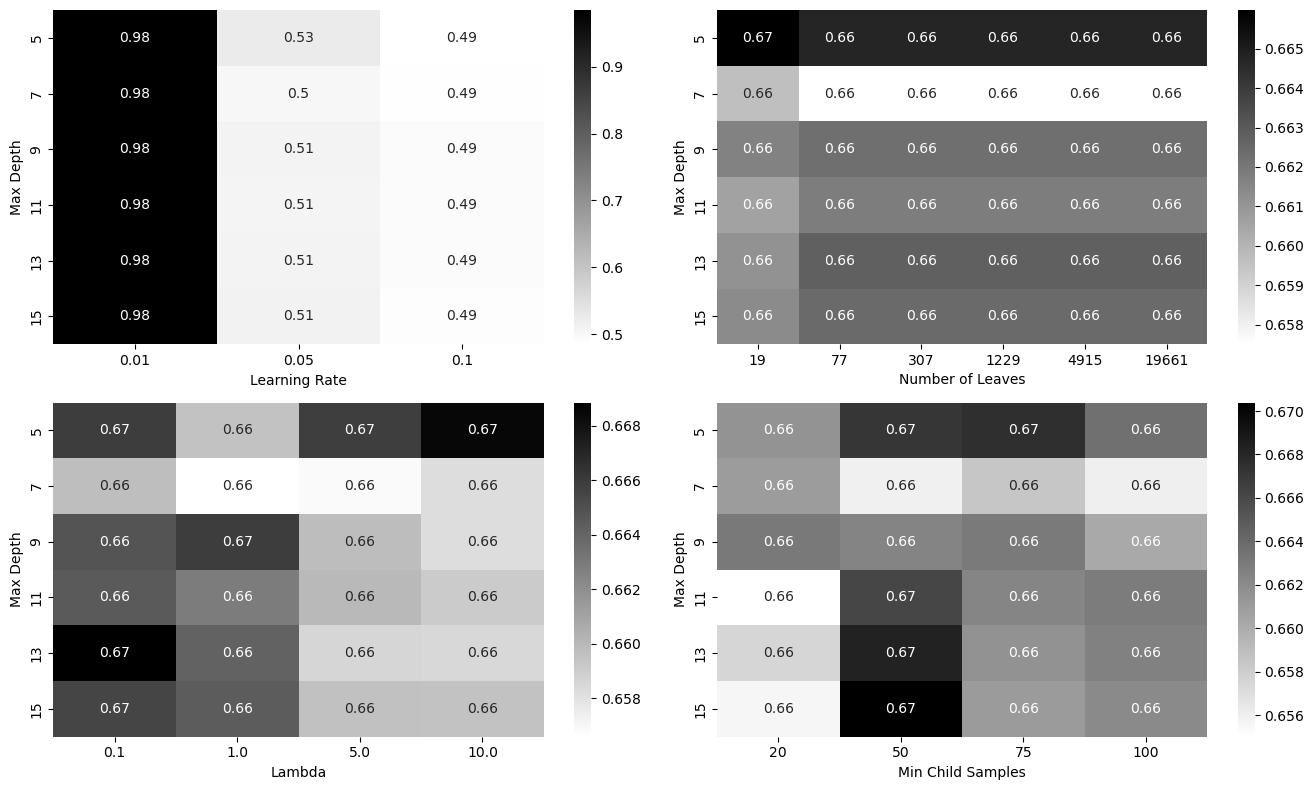

In [22]:
# Get the results as a dataframe
results_df = pd.DataFrame(lgbm_b_grid.cv_results_)
results_df['mean_test_score'] = abs(results_df['mean_test_score'] )

# Create subplots for the heatmaps
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(13.5, 8))

# Plot the first heatmap
heatmap_data = results_df.pivot_table(values='mean_test_score', index='param_gb__max_depth', columns='param_gb__learning_rate')
ax = sns.heatmap(heatmap_data, annot=True, cmap='gray_r', ax=axs[0, 0])
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Max Depth')

# Plot the second heatmap
heatmap_data = results_df.pivot_table(values='mean_test_score', index='param_gb__max_depth', columns='param_gb__num_leaves')
ax = sns.heatmap(heatmap_data, annot=True, cmap='gray_r', ax=axs[0, 1])
ax.set_xlabel('Number of Leaves')
ax.set_ylabel('Max Depth')

# Plot the third heatmap
heatmap_data = results_df.pivot_table(values='mean_test_score', index='param_gb__max_depth', columns='param_gb__reg_lambda')
ax = sns.heatmap(heatmap_data, annot=True, cmap='gray_r', ax=axs[1, 0])
ax.set_xlabel('Lambda')
ax.set_ylabel('Max Depth')

# Plot the fourth heatmap
heatmap_data = results_df.pivot_table(values='mean_test_score', index='param_gb__max_depth', columns='param_gb__min_child_samples')
ax = sns.heatmap(heatmap_data, annot=True, cmap='gray_r', ax=axs[1, 1])
ax.set_xlabel('Min Child Samples')
ax.set_ylabel('Max Depth')

# Display the plot
plt.tight_layout()
plt.show()
fig.savefig("lgbm_param.jpg", dpi=300, bbox_inches='tight')